# Notebook Setup

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
cd /content/drive/MyDrive/itau/

/content/drive/.shortcut-targets-by-id/1aUC5RchZtFpeGyPvJo-XMSlXMbwngk3G/itau


In [7]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate ,GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, f1_score
import matplotlib.pyplot as plt
from dataset.dataset import Dataset

In [10]:
ds = Dataset()

In [11]:
ds.load_data()

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


# Model

## Functions version 0

In [ ]:
def get_features_customers(customers_df):
  features_customers = ['id','Principalidad','Segmento_consumidor','Recibe_sueldo_en_cuenta','Meses_antiguedad']
  features_customers_df = customers_df[features_customers].copy()
  features_customers_df.at[:,'antiquity_1_year'] = [(not (x == 'Menos de 1 año'))*1 for x in features_customers_df.Meses_antiguedad ]
  features_customers_df.at[:,'segmento_A'] =[(x=='A')*1 for x in features_customers_df.Segmento_consumidor]
  principalidad_dummies = get_dummies_principalidad(features_customers_df)
  features_customers_df = features_customers_df.merge(principalidad_dummies, how='left', left_on='id', right_index = True)
  features_customers_df.drop(columns=['Meses_antiguedad','Segmento_consumidor','Principalidad'],inplace=True)
  return features_customers_df

def get_dummies_principalidad(features_customers_df_o):
  features_customers_df = features_customers_df_o.copy()
  features_customers_df = features_customers_df.astype({'Principalidad':'object'})
  features_customers_df.Principalidad.fillna('N',inplace=True)
  principalidad_dummies = pd.get_dummies(features_customers_df.set_index('id').Principalidad,prefix='Prin_')
  return principalidad_dummies
  

def get_info_months(df_transactions_product, list_months, previous_months = True):
  mask_last =  df_transactions_product["Periodo"].apply(lambda x: x in list_months)
  df_last = pd.DataFrame(data = list(df_transactions_product[mask_last].id.unique()), columns = ['id'])
  name_col = 'last_n_months_bought' if previous_months else 'last_n_months_year_bought'
  df_last.at[:, name_col] = 1
  return df_last

def get_data_transactions(features_customers_df, df_transactions_product, list_last_months, list_last_year_months):
  df_last_months = get_info_months(df_transactions_product, list_last_months)
  df_last_months_year = get_info_months(df_transactions_product, list_last_year_months, previous_months= False)
  data_transactions = features_customers_df.merge(df_last_months, how='left',on='id')
  data_transactions = data_transactions.merge(df_last_months_year, how='left',on='id')
  return data_transactions

def get_df_transactions_product(transactions_df_o, product):
  mask_product = (transactions_df_o["Producto-Tipo"] == product)
  df_transactions_product = transactions_df_o[mask_product].copy()
  return df_transactions_product

def get_data_campains(campains_df, data_out_campains, list_3_months, product):
  mask_campain_product = (campains_df["Producto-Tipo"] == product)
  campain_product_df = campains_df[mask_campain_product].copy()
  mask_campains =  campain_product_df["Periodo"].apply(lambda x: x in list_3_months)
  df_campains = pd.DataFrame(data = list(campain_product_df[mask_campains].id.unique()), columns = ['id'])
  df_campains.at[:,'campain'] = 1
  data = data_out_campains.merge(df_campains, how='left',on='id')
  return data

def get_labels(df_transactions_product, features_customers_df, list_3_months_labels_train):
  mask_labels =  df_transactions_product["Periodo"].apply(lambda x: x in list_3_months_labels_train)
  df_labels = pd.DataFrame(data = list(df_transactions_product[mask_labels].id.unique()), columns = ['id'])
  df_labels.at[:,'labels'] = 1
  ids_df = pd.DataFrame(features_customers_df.id)
  df_labels = ids_df.merge(df_labels, how='left', on = 'id')
  df_labels.labels.fillna(0,inplace=True)
  return df_labels

def fill_na_data(data_o,campain =True):
  data = data_o.copy()
  data.last_n_months_bought.fillna(0,inplace=True)
  data.last_n_months_year_bought.fillna(0,inplace=True)
  if campain:
    data.campain.fillna(0,inplace=True)
  return data

## Grid search random forest

In [ ]:
list_3_months_labels_train = [202005,202006,202007]
list_3_last_months_train = [202002,202003,202004]
list_last_year_3_months_train = [201905,201906,201907]

list_3_months_campain_test = [202008,202009,202010]
list_3_last_months_test = [202005,202006,202007]
list_last_year_3_months_test = [201908,201909,201910]

products  = ["A-A", "B-B", "C-D", "D-E", "E-E"]
dic_deltas = {"A-A":-0.01, "B-B":-0.01, "C-D":-0.01, "D-E":0.0, "E-E":-0.01}
dic_epsilons = {"A-A":0.1, "B-B":0.2, "C-D":0.4, "D-E":0.5, "E-E":0.3}
define_df_entrega = True
features_customers_df = get_features_customers(ds.customers_df)
for product in products:
  df_transactions_product = get_df_transactions_product(ds.transactions_train_df, product)
  data_train_out_campains = get_data_transactions(features_customers_df, df_transactions_product,
                                                  list_3_last_months_train, list_last_year_3_months_train)
  data_test_out_campains  = get_data_transactions(features_customers_df, df_transactions_product,
                                                  list_3_last_months_test, list_last_year_3_months_test)

  if products in ["A-A"]:
    data_train_nas = get_data_campains(ds.campains_train_df, data_train_out_campains, list_3_months_labels_train, product)
    data_test_nas  = get_data_campains(ds.campains_test_df, data_test_out_campains, list_3_months_campain_test, product)
    data_train = fill_na_data(data_train_nas)
    data_test = fill_na_data(data_test_nas)
  else:
    data_train_nas = data_train_out_campains
    data_test_nas = data_test_out_campains
    data_train = fill_na_data(data_train_nas,campain =False)
    data_test = fill_na_data(data_test_nas,campain = False)
  
  if product != "B-B":
    mask_train = (df_transactions_product.Periodo < 202005) & (df_transactions_product.Periodo > 201904)
    mask_test = (df_transactions_product.Periodo < 202008)  & (df_transactions_product.Periodo > 201907)
  else:
    mask_train = (df_transactions_product.Periodo < 202005) & (df_transactions_product.Periodo > 201907)
    mask_test = (df_transactions_product.Periodo < 202008)  & (df_transactions_product.Periodo > 201910)
  
  months_features_train = pd.pivot_table(df_transactions_product[mask_train],index='id',values='Monto',columns='Periodo',fill_value=0)
  months_features_test = pd.pivot_table(df_transactions_product[mask_test],index='id',values='Monto',columns='Periodo',fill_value=0)
  months_features_train = (months_features_train!=0)*1
  months_features_test = (months_features_test!=0)*1
  ids_months = pd.DataFrame(data = data_test.id)
  months_features_train = ids_months.merge(months_features_train.reset_index(),how ='left', on ='id')
  months_features_test = ids_months.merge(months_features_test.reset_index(),how ='left', on ='id')
  months_features_train.fillna(0,inplace=True)
  months_features_test.fillna(0,inplace=True)
  data_train = data_train.merge(months_features_train,how='left',on='id')
  data_test = data_test.merge(months_features_test,how='left',on='id')

  df_labels = get_labels(df_transactions_product, features_customers_df, list_3_months_labels_train)
  X_train = data_train.drop(columns='id')
  X_test  = data_test.drop(columns='id')
  y = df_labels['labels']
  scoring = 'roc_auc'
  dic_grid_params = { "A-A": {'n_estimators': [100,150,200],'max_depth': [15,20,25]},
                      "B-B": {'n_estimators': [40,50,75],'max_depth': [25,30,35]}, 
                      "C-D": {'n_estimators': [100,150,200],'max_depth': [25,30,35]},
                      "D-E": {'n_estimators': [100,150,200],'max_depth': [15,20,25]},
                      "E-E": {'n_estimators': [100,150,200],'max_depth': [15,20,25]}}
  model = RandomForestClassifier()
  grid_cv = GridSearchCV(model, param_grid = dic_grid_params[product] , scoring=scoring)
  grid_cv.fit(X_train,y)
  percen = (1-sum(df_labels.labels)/len(df_labels))
  print('proporcion test',sum(df_labels.labels)/len(df_labels))
  q = np.quantile(grid_cv.predict_proba(X_test)[:,1], percen) + dic_deltas[product]
  print(q,product)
  print(grid_cv.best_params_)
  print(grid_cv.best_score_)
  if define_df_entrega:
    ids_entrega = pd.DataFrame(data = data_test.id)
    define_df_entrega = False
  ids_entrega.at[:,product] = [(x>q)*1 +dic_epsilons[product]  for x in grid_cv.predict_proba(X_test)[:,1] ]
  print('proporcion prediccion', sum(ids_entrega[product]>1)/len(ids_entrega))
  print('***********************************************************************************')

proporcion test 0.022391531198531538
0.07685777965303421 A-A
{'max_depth': 15, 'n_estimators': 100}
0.6344205967206942
proporcion prediccion 0.02505689033052968
***********************************************************************************
proporcion test 0.08969184928148455
0.12686978115927516 B-B
{'max_depth': 35, 'n_estimators': 75}
0.5629204080494542
proporcion prediccion 0.11821873546310616
***********************************************************************************
proporcion test 0.20674134701215754
0.5052028905778956 C-D
{'max_depth': 25, 'n_estimators': 150}
0.9428743415543993
proporcion prediccion 0.20752083883377964
***********************************************************************************
proporcion test 0.2960937401777744
0.3279196065158082 D-E
{'max_depth': 15, 'n_estimators': 200}
0.867908342679004
proporcion prediccion 0.29606859528030277
***********************************************************************************
proporcion test 0.0700662568

## Random Forest features importances

proporcion test 0.022391531198531538
0.08482662835071679 A-A
auc in train (do not metric for model) 0.778991472542426
proporcion prediccion 0.024931165843171274


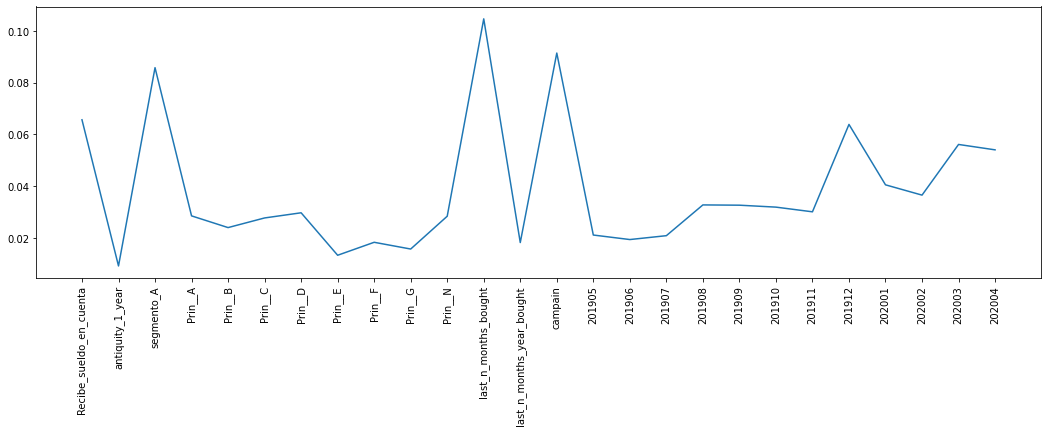

***********************************************************************************
***********************************************************************************
proporcion test 0.08969184928148455
0.1287866473907242 B-B
auc in train (do not metric for model) 0.6660764730490794
proporcion prediccion 0.11268685801933642


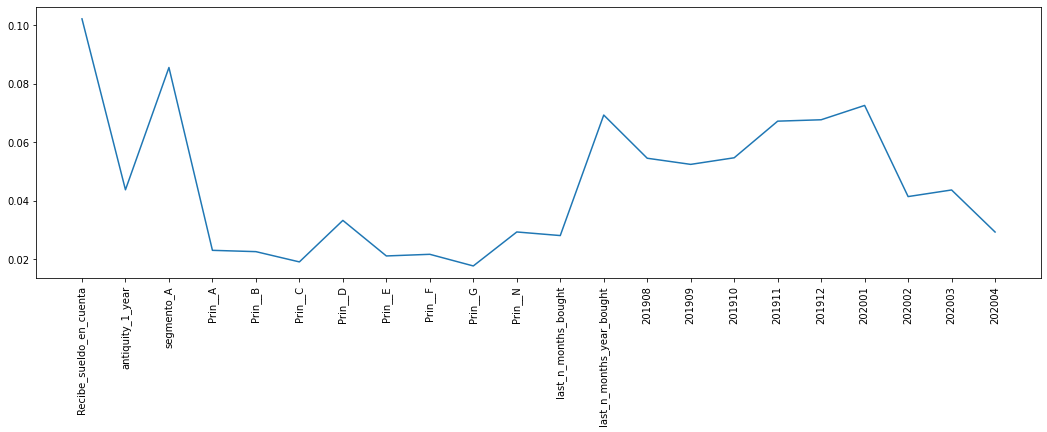

***********************************************************************************
***********************************************************************************
proporcion test 0.20674134701215754
0.55 C-D
auc in train (do not metric for model) 0.9832290860046653
proporcion prediccion 0.2074076867951571


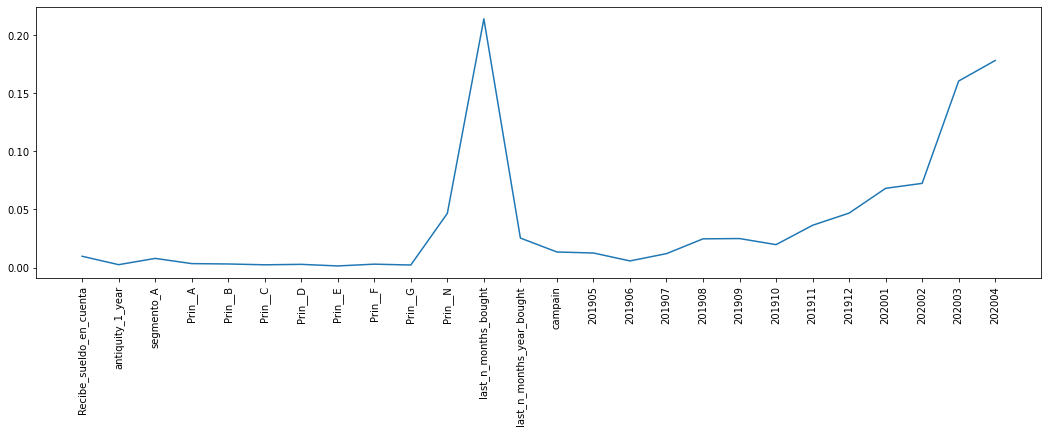

***********************************************************************************
***********************************************************************************
proporcion test 0.2960937401777744
0.33273459644861014 D-E
auc in train (do not metric for model) 0.8896260330866014
proporcion prediccion 0.2960308779340952


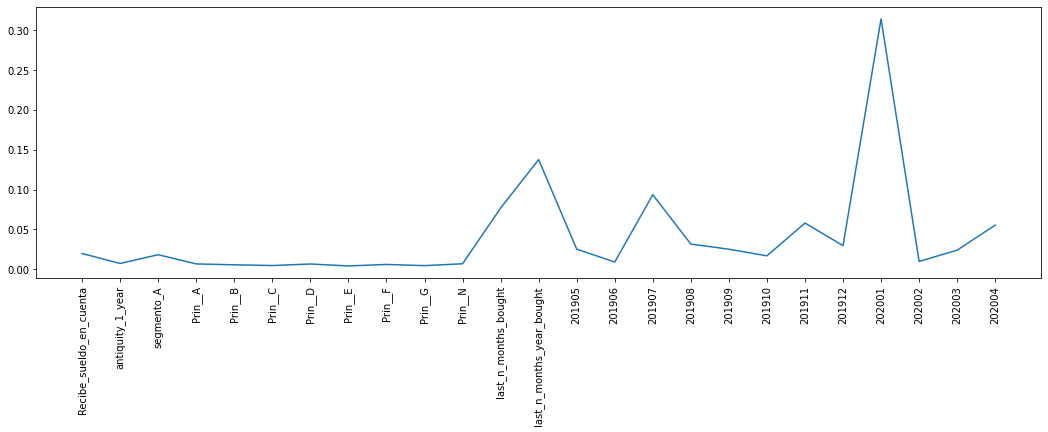

***********************************************************************************
***********************************************************************************
proporcion test 0.07006625680483788
0.21946707664096315 E-E
auc in train (do not metric for model) 0.8813396491758166
proporcion prediccion 0.07283219552672274


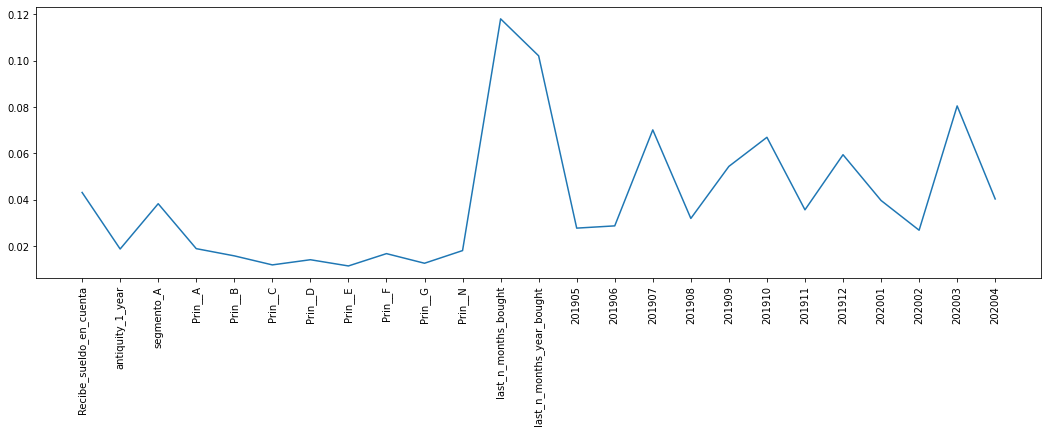

***********************************************************************************
***********************************************************************************


In [ ]:
list_3_months_labels_train = [202005,202006,202007]
list_3_last_months_train = [202002,202003,202004]
list_last_year_3_months_train = [201905,201906,201907]

list_3_months_campain_test = [202008,202009,202010]
list_3_last_months_test = [202005,202006,202007]
list_last_year_3_months_test = [201908,201909,201910]

products  = ["A-A", "B-B", "C-D", "D-E", "E-E"]
dic_deltas = {"A-A":-0.01, "B-B":-0.01, "C-D":-0.01, "D-E":0.0, "E-E":-0.01}
dic_epsilons = {"A-A":0.1, "B-B":0.2, "C-D":0.4, "D-E":0.5, "E-E":0.3}
define_df_entrega = True
features_customers_df = get_features_customers(ds.customers_df)
for product in products:
  df_transactions_product = get_df_transactions_product(ds.transactions_train_df, product)
  data_train_out_campains = get_data_transactions(features_customers_df, df_transactions_product,
                                                  list_3_last_months_train, list_last_year_3_months_train)
  data_test_out_campains  = get_data_transactions(features_customers_df, df_transactions_product,
                                                  list_3_last_months_test, list_last_year_3_months_test)

  if product in ["A-A","C-D"]:
    data_train_nas = get_data_campains(ds.campains_train_df, data_train_out_campains, list_3_months_labels_train, product)
    data_test_nas  = get_data_campains(ds.campains_test_df, data_test_out_campains, list_3_months_campain_test, product)
    data_train = fill_na_data(data_train_nas)
    data_test = fill_na_data(data_test_nas)
  else:
    data_train_nas = data_train_out_campains
    data_test_nas = data_test_out_campains
    data_train = fill_na_data(data_train_nas,campain =False)
    data_test = fill_na_data(data_test_nas,campain = False)
  
  if product != "B-B":
    mask_train = (df_transactions_product.Periodo < 202005) & (df_transactions_product.Periodo > 201904)
    mask_test = (df_transactions_product.Periodo < 202008)  & (df_transactions_product.Periodo > 201907)
  else:
    mask_train = (df_transactions_product.Periodo < 202005) & (df_transactions_product.Periodo > 201907)
    mask_test = (df_transactions_product.Periodo < 202008)  & (df_transactions_product.Periodo > 201910)
  
  months_features_train = pd.pivot_table(df_transactions_product[mask_train],index='id',values='Monto',columns='Periodo',fill_value=0)
  months_features_test = pd.pivot_table(df_transactions_product[mask_test],index='id',values='Monto',columns='Periodo',fill_value=0)
  months_features_train = (months_features_train!=0)*1
  months_features_test = (months_features_test!=0)*1
  ids_months = pd.DataFrame(data = data_test.id)
  months_features_train = ids_months.merge(months_features_train.reset_index(),how ='left', on ='id')
  months_features_test = ids_months.merge(months_features_test.reset_index(),how ='left', on ='id')
  months_features_train.fillna(0,inplace=True)
  months_features_test.fillna(0,inplace=True)
  data_train = data_train.merge(months_features_train,how='left',on='id')
  data_test = data_test.merge(months_features_test,how='left',on='id')

  df_labels = get_labels(df_transactions_product, features_customers_df, list_3_months_labels_train)
  X_train = data_train.drop(columns='id')
  X_test  = data_test.drop(columns='id')
  y = df_labels['labels']
  scoring = 'roc_auc'
  dic_grid_params = { "A-A": {'n_estimators': 100,'max_depth': 15},
                      "B-B": {'n_estimators': 75,'max_depth': 35}, 
                      "C-D": {'n_estimators': 150,'max_depth': 25},
                      "D-E": {'n_estimators': 200,'max_depth': 15},
                      "E-E": {'n_estimators': 100,'max_depth': 15}}
  model = RandomForestClassifier(n_estimators=dic_grid_params[product]['n_estimators'], max_depth=dic_grid_params[product]['max_depth'])
  model.fit(X_train,y)
  percen = (1-sum(df_labels.labels)/len(df_labels))
  print('proporcion test',sum(df_labels.labels)/len(df_labels))
  q = np.quantile(model.predict_proba(X_test)[:,1], percen) + dic_deltas[product]
  print(q,product)
  #print(model.best_params_)
  #print(grid_cv.best_score_)
  print('auc in train (do not metric for model)',roc_auc_score(y,model.predict_proba(X_train)[:,1]))
  if define_df_entrega:
    ids_entrega = pd.DataFrame(data = data_test.id)
    define_df_entrega = False
  ids_entrega.at[:,product] = [(x>q)*1 +dic_epsilons[product]  for x in model.predict_proba(X_test)[:,1] ]
  print('proporcion prediccion', sum(ids_entrega[product]>1)/len(ids_entrega))
  plt.figure(figsize=(18,5))
  plt.plot(model.feature_importances_)
  plt.xticks(ticks=range(len(model.feature_importances_)),labels=list(X_train.columns),rotation = 90)
  plt.show()
  print('***********************************************************************************')
  print('***********************************************************************************')

## Functions version 1

In [200]:
def get_features_customers(customers_df,features_customers):
  features_customers_df = customers_df[features_customers].copy()
  if 'Meses_antiguedad' in  features_customers_df.columns:
    features_customers_df.at[:,'antiquity_1_year'] = [(not (x == 'Menos de 1 año'))*1 for x in features_customers_df.Meses_antiguedad ]
  features_customers_df.at[:,'segmento_A'] =[(x=='A')*1 for x in features_customers_df.Segmento_consumidor]
  cols = ['Segmento_consumidor']
  cols = cols + ['Meses_antiguedad'] if 'Meses_antiguedad' in  features_customers_df.columns else cols
  features_customers_df.drop(columns= cols,inplace=True)
  return features_customers_df

def get_dummies_principalidad(features_customers_df_o):
  features_customers_df = features_customers_df_o.copy()
  features_customers_df = features_customers_df.astype({'Principalidad':'object'})
  features_customers_df.Principalidad.fillna('N',inplace=True)
  principalidad_dummies = pd.get_dummies(features_customers_df.set_index('id').Principalidad,prefix='Prin_')
  return principalidad_dummies
  
def get_months_features(df_transactions_product, data_id, mask):
  months_features = pd.pivot_table(df_transactions_product[mask],index='id',values='Monto',columns='Periodo',fill_value=0)
  months_features = (months_features!=0)*1
  ids_months = pd.DataFrame(data = data_test.id)
  months_features = ids_months.merge(months_features.reset_index(),how ='left', on ='id')
  months_features.fillna(0,inplace=True)
  return months_features

def get_info_months(df_transactions_product, list_months, previous_months = True):
  mask_last =  df_transactions_product["Periodo"].apply(lambda x: x in list_months)
  df_last = pd.DataFrame(data = list(df_transactions_product[mask_last].id.unique()), columns = ['id'])
  name_col = 'last_n_months_bought' if previous_months else 'last_n_months_year_bought'
  df_last.at[:, name_col] = 1
  return df_last

def get_data_transactions(features_customers_df, df_transactions_product, list_last_months =[], list_last_year_months=[]):
  if (list_last_months == []) and (list_last_year_months != []):
    df_last_months_year = get_info_months(df_transactions_product, list_last_year_months, previous_months= False)
    data_transactions = features_customers_df.merge(df_last_months_year, how='left',on='id')
  elif (list_last_months != []) and (list_last_year_months == []):
    df_last_months = get_info_months(df_transactions_product, list_last_months, previous_months= False)
    data_transactions = features_customers_df.merge(df_last_months, how='left',on='id')
  elif (list_last_months != []) and (list_last_year_months != []):
    df_last_months = get_info_months(df_transactions_product, list_last_months)
    df_last_months_year = get_info_months(df_transactions_product, list_last_year_months, previous_months= False)
    data_transactions = features_customers_df.merge(df_last_months, how='left',on='id')
    data_transactions = data_transactions.merge(df_last_months_year, how='left',on='id')
  return data_transactions

def get_df_transactions_product(transactions_df_o, product):
  mask_product = (transactions_df_o["Producto-Tipo"] == product)
  df_transactions_product = transactions_df_o[mask_product].copy()
  return df_transactions_product

def get_data_campains(campains_df, data_out_campains, list_3_months, product):
  mask_campain_product = (campains_df["Producto-Tipo"] == product)
  mask_campain_duration = (campains_df["Duracion_Campaña"]  < 3)
  campain_product_df = campains_df[(mask_campain_product & mask_campain_duration)].copy()
  mask_campains_period =  campain_product_df["Periodo"].apply(lambda x: x in list_3_months)
  df_campains = pd.DataFrame(data = list(campain_product_df[mask_campains_period].id.unique()), columns = ['id'])
  df_campains.at[:,'campain'] = 1
  data = data_out_campains.merge(df_campains, how='left',on='id')
  return data

def get_labels(df_transactions_product, features_customers_df, list_3_months_labels_train):
  mask_labels =  df_transactions_product["Periodo"].apply(lambda x: x in list_3_months_labels_train)
  df_labels = pd.DataFrame(data = list(df_transactions_product[mask_labels].id.unique()), columns = ['id'])
  df_labels.at[:,'labels'] = 1
  ids_df = pd.DataFrame(features_customers_df.id)
  df_labels = ids_df.merge(df_labels, how='left', on = 'id')
  df_labels.labels.fillna(0,inplace=True)
  return df_labels

def fill_na_data(data_o):
  data = data_o.copy()
  if 'last_n_months_bought' in data.columns:
    data.last_n_months_bought.fillna(0,inplace=True)
  if 'last_n_months_year_bought' in data.columns:
    data.last_n_months_year_bought.fillna(0,inplace=True)
  if 'campain' in data.columns:
    data.campain.fillna(0,inplace=True)
  return data

def precision_treshold_based_score(proba_test, pred_proba,y):
  dic_scores = {}
  for p in pd.Series(proba_test).unique():
    y_pred_tre = ((pred_proba>=p)*1)
    if sum(y_pred_tre)==0:
      dic_scores[p] = 1
    else:
      dic_scores[p] = precision_score(y,y_pred_tre)
  return dic_scores

## Random Forest model

In [201]:
list_3_months_labels_train = [202005,202006,202007]
list_3_last_months_train = [202002,202003,202004]
list_last_year_3_months_train = [201905,201906,201907]

list_3_months_campain_test = [202008,202009,202010]
list_3_last_months_test = [202005,202006,202007]
list_last_year_3_months_test = [201908,201909,201910]

dic_deltas = {"A-A":0.05, "B-B":0.03, "C-D":0.03, "D-E":0.09, "E-E":0.01}
dic_epsilons_1 = {"A-A":0.3, "B-B":0.2, "C-D":0.5, "D-E":0.1, "E-E":0.4}
dic_epsilons_0 = {"A-A":0.1, "B-B":0.2, "C-D":0.5, "D-E":0.4, "E-E":0.3}

### Model A-A

In [202]:

############## Model for A-A ############################################
product = 'A-A'
features_customers = ['id','Segmento_consumidor','Recibe_sueldo_en_cuenta']
features_customers_df = get_features_customers(ds.customers_df,features_customers)

df_transactions_product = get_df_transactions_product(ds.transactions_train_df, product)

data_train_out_campains = get_data_transactions(features_customers_df, df_transactions_product, list_last_months = list_3_last_months_train)
data_test_out_campains  = get_data_transactions(features_customers_df, df_transactions_product, list_last_months = list_3_last_months_test)

data_train_nas = get_data_campains(ds.campains_train_df, data_train_out_campains, list_3_months_labels_train, product)
data_test_nas  = get_data_campains(ds.campains_test_df, data_test_out_campains, list_3_months_campain_test, product)


data_train = fill_na_data(data_train_nas)
data_test = fill_na_data(data_test_nas)

mask_train = (df_transactions_product.Periodo < 202005) & (df_transactions_product.Periodo > 201904)
mask_test = (df_transactions_product.Periodo < 202008)  & (df_transactions_product.Periodo > 201907)
months_features_train = get_months_features(df_transactions_product, data_train, mask_train)
months_features_test = get_months_features(df_transactions_product, data_test, mask_test)

data_train = data_train.merge(months_features_train,how='left',on='id')
data_test = data_test.merge(months_features_test,how='left',on='id')

df_labels = get_labels(df_transactions_product, features_customers_df, list_3_months_labels_train)
X_train = data_train.drop(columns='id')
X_test  = data_test.drop(columns='id')
y = df_labels['labels']
params = {'n_estimators': 100,'max_depth': 35}
model = RandomForestClassifier(n_estimators=params['n_estimators'], max_depth=params['max_depth'])
model.fit(X_train,y)
print('auc in train (do not metric for model)',roc_auc_score(y,model.predict_proba(X_train)[:,1]))

percen = (1-sum(df_labels.labels)/len(df_labels))
q = np.quantile(model.predict_proba(X_test)[:,1], percen) + dic_deltas[product]

ids_entrega = pd.DataFrame(data = data_test.id)                    ################## only in A-A delete in others

predict_proba_train = model.predict_proba(X_train)[:,1]
predict_proba_test  = model.predict_proba(X_test)[:,1]
dic_scores = precision_treshold_based_score(predict_proba_test, predict_proba_train,y)
prec_base = sum(y)/len(y)
ids_entrega.at[:,product] = [dic_scores[x]-prec_base for x in predict_proba_test ]   ###  
#ids_entrega.at[:,product] = model.predict(X_test)

y_pred = model.predict(X_train)

print('proporcion true 1',sum(df_labels.labels)/len(df_labels))
print('proporcion prediccion', sum(ids_entrega[product]>dic_epsilons_1[product])/len(ids_entrega))
print('acurracy in  train ',accuracy_score(y,y_pred))
print('precision in  train ',precision_score(y,y_pred))
print('***********************************************************************************')
print('***********************************************************************************')
plt.figure(figsize=(18,5))
plt.plot(model.feature_importances_)
plt.xticks(ticks=range(len(model.feature_importances_)),labels=list(X_train.columns),rotation = 90)
plt.ylim(0,max(model.feature_importances_))
plt.show()
plt.hist(model.predict_proba(X_train)[:,1],bins=50)
plt.show()
plt.scatter(x=list(dic_scores.keys()),y=list(dic_scores.values()))

NameError: ignored

### Model B-B

auc in train (do not metric for model) 0.6634441954207873
proporcion true 1 0.08969184928148455
proporcion prediccion 0.03742817988659651
acurracy in  train  0.9130363720941927
precision in  train  0.8604651162790697
***********************************************************************************
***********************************************************************************


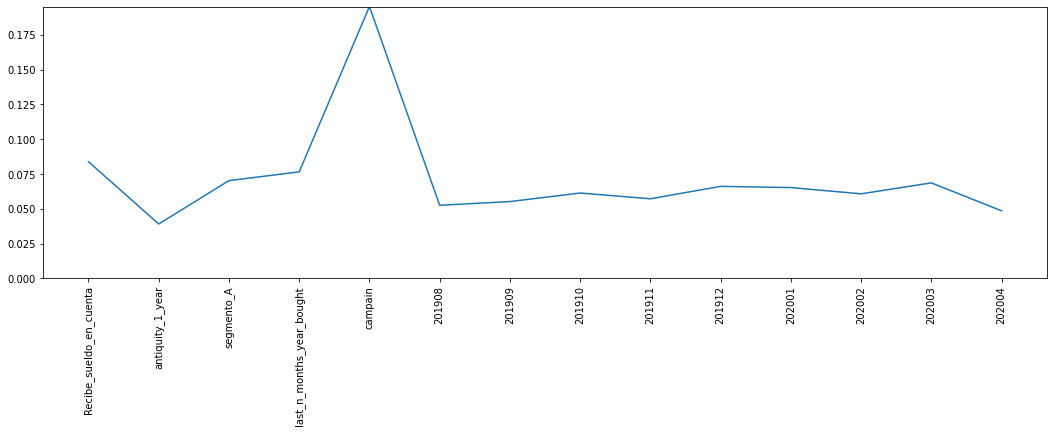

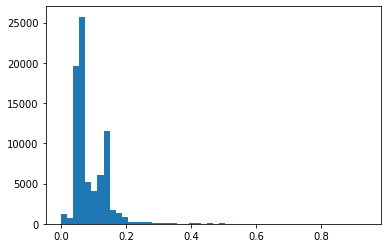

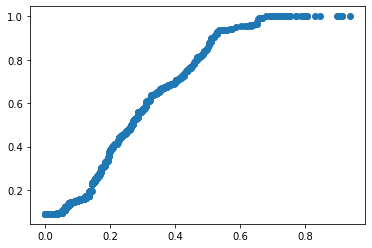

In [ ]:
product = 'B-B'
features_customers = ['id','Segmento_consumidor','Recibe_sueldo_en_cuenta','Meses_antiguedad']
features_customers_df = get_features_customers(ds.customers_df,features_customers)

df_transactions_product = get_df_transactions_product(ds.transactions_train_df, product)

data_train_out_campains = get_data_transactions(features_customers_df, df_transactions_product, list_last_year_months = list_last_year_3_months_train)
data_test_out_campains  = get_data_transactions(features_customers_df, df_transactions_product, list_last_year_months = list_last_year_3_months_test)

data_train_nas = get_data_campains(ds.campains_train_df, data_train_out_campains, list_3_months_labels_train, product)
data_test_nas  = get_data_campains(ds.campains_test_df, data_test_out_campains, list_3_months_campain_test, product)

data_train = fill_na_data(data_train_nas)
data_test = fill_na_data(data_test_nas)

mask_train = (df_transactions_product.Periodo < 202005) & (df_transactions_product.Periodo > 201907)
mask_test = (df_transactions_product.Periodo < 202008)  & (df_transactions_product.Periodo > 201910)
months_features_train = get_months_features(df_transactions_product, data_train, mask_train)
months_features_test = get_months_features(df_transactions_product, data_test, mask_test)

data_train = data_train.merge(months_features_train,how='left',on='id')
data_test = data_test.merge(months_features_test,how='left',on='id')

df_labels = get_labels(df_transactions_product, features_customers_df, list_3_months_labels_train)
X_train = data_train.drop(columns='id')
X_test  = data_test.drop(columns='id')
y = df_labels['labels']
params = {'n_estimators': 100,'max_depth': 35}
model = RandomForestClassifier(n_estimators=params['n_estimators'], max_depth=params['max_depth'])
model.fit(X_train,y)
print('auc in train (do not metric for model)',roc_auc_score(y,model.predict_proba(X_train)[:,1]))

percen = (1-sum(df_labels.labels)/len(df_labels))
q = np.quantile(model.predict_proba(X_test)[:,1], percen) + dic_deltas[product]

predict_proba_train = model.predict_proba(X_train)[:,1]
predict_proba_test  = model.predict_proba(X_test)[:,1]
dic_scores = precision_treshold_based_score(predict_proba_test, predict_proba_train,y)
prec_base = sum(y)/len(y)
ids_entrega.at[:,product] = [dic_scores[x]-prec_base for x in predict_proba_test ]   ###  
#ids_entrega.at[:,product] = model.predict(X_test)

y_pred = model.predict(X_train)
print('proporcion true 1',sum(df_labels.labels)/len(df_labels))
print('proporcion prediccion', sum(ids_entrega[product]>dic_epsilons_1[product])/len(ids_entrega))
print('acurracy in  train ',accuracy_score(y,y_pred))
print('precision in  train ',precision_score(y,y_pred))
print('***********************************************************************************')
print('***********************************************************************************')
plt.figure(figsize=(18,5))
plt.plot(model.feature_importances_)
plt.xticks(ticks=range(len(model.feature_importances_)),labels=list(X_train.columns),rotation = 90)
plt.ylim(0,max(model.feature_importances_))
plt.show()
plt.hist(model.predict_proba(X_train)[:,1],bins=50)
plt.show()
plt.scatter(x=list(dic_scores.keys()),y=list(dic_scores.values()))

### Model C-D

auc in train (do not metric for model) 0.9402742322185473
proporcion true 1 0.20674134701215754
proporcion prediccion 0.22054589572411018
acurracy in  train  0.9498107846465256
precision in  train  0.9082087595069499
***********************************************************************************
***********************************************************************************


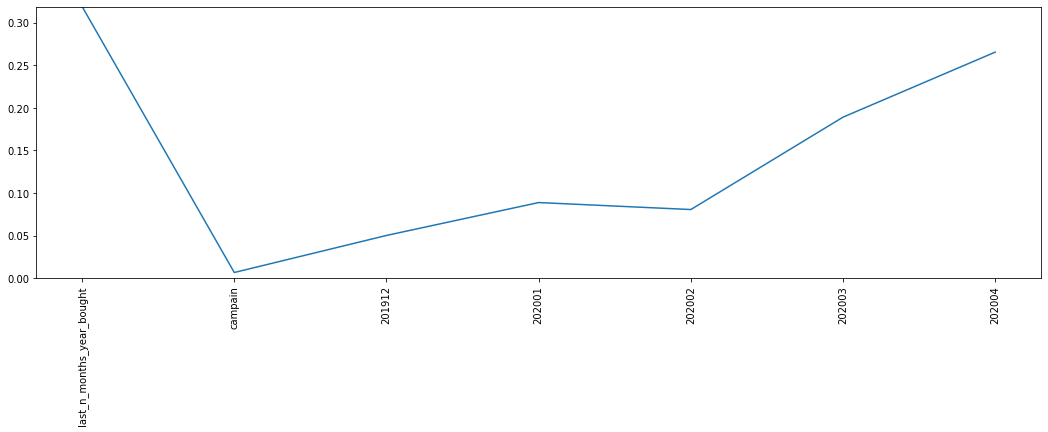

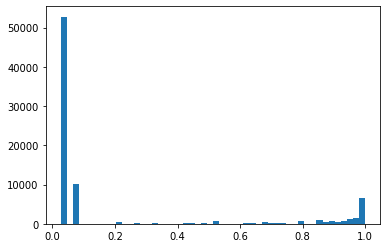

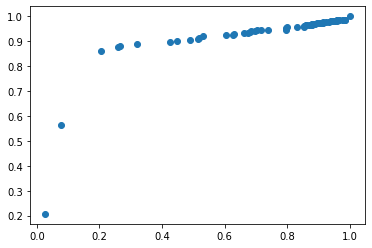

In [ ]:
product = 'C-D'
features_customers = ['id','Segmento_consumidor']
features_customers_df = get_features_customers(ds.customers_df,features_customers)

df_transactions_product = get_df_transactions_product(ds.transactions_train_df, product)

data_train_out_campains = get_data_transactions(features_customers_df, df_transactions_product, list_last_months = list_3_last_months_train)
data_test_out_campains  = get_data_transactions(features_customers_df, df_transactions_product, list_last_months = list_3_last_months_test)

data_train_nas = get_data_campains(ds.campains_train_df, data_train_out_campains, list_3_months_labels_train, product)
data_test_nas  = get_data_campains(ds.campains_test_df, data_test_out_campains, list_3_months_campain_test, product)

data_train = fill_na_data(data_train_nas)
data_test = fill_na_data(data_test_nas)

mask_train = (df_transactions_product.Periodo < 202005) & (df_transactions_product.Periodo > 201911)
mask_test = (df_transactions_product.Periodo < 202008)  & (df_transactions_product.Periodo > 202002)
months_features_train = get_months_features(df_transactions_product, data_train, mask_train)
months_features_test = get_months_features(df_transactions_product, data_test, mask_test)

data_train = data_train.merge(months_features_train,how='left',on='id')
data_train.drop(columns='segmento_A',inplace = True)
data_test = data_test.merge(months_features_test,how='left',on='id')
data_test.drop(columns='segmento_A',inplace = True)

df_labels = get_labels(df_transactions_product, features_customers_df, list_3_months_labels_train)
X_train = data_train.drop(columns='id')
X_test  = data_test.drop(columns='id')
y = df_labels['labels']
params = {'n_estimators': 100,'max_depth': 35}
model = RandomForestClassifier(n_estimators=params['n_estimators'], max_depth=params['max_depth'])
model.fit(X_train,y)
print('auc in train (do not metric for model)',roc_auc_score(y,model.predict_proba(X_train)[:,1]))

percen = (1-sum(df_labels.labels)/len(df_labels))
q = np.quantile(model.predict_proba(X_test)[:,1], percen) + dic_deltas[product]


predict_proba_train = model.predict_proba(X_train)[:,1]
predict_proba_test  = model.predict_proba(X_test)[:,1]
dic_scores = precision_treshold_based_score(predict_proba_test, predict_proba_train,y)
prec_base = sum(y)/len(y)
ids_entrega.at[:,product] = [dic_scores[x]-prec_base for x in predict_proba_test ]   ###  
#ids_entrega.at[:,product] = model.predict(X_test)

y_pred = model.predict(X_train)
print('proporcion true 1',sum(df_labels.labels)/len(df_labels))
print('proporcion prediccion', sum(ids_entrega[product]>dic_epsilons_1[product])/len(ids_entrega))
print('acurracy in  train ',accuracy_score(y,y_pred))
print('precision in  train ',precision_score(y,y_pred))
print('***********************************************************************************')
print('***********************************************************************************')
plt.figure(figsize=(18,5))
plt.plot(model.feature_importances_)
plt.xticks(ticks=range(len(model.feature_importances_)),labels=list(X_train.columns),rotation = 90)
plt.ylim(0,max(model.feature_importances_))
plt.show()
plt.hist(model.predict_proba(X_train)[:,1],bins=50)
plt.show()
plt.scatter(x=list(dic_scores.keys()),y=list(dic_scores.values()))

### Model D-E

auc in train (do not metric for model) 0.8526803553235371
proporcion true 1 0.2960937401777744
proporcion prediccion 0.44618363318623566
acurracy in  train  0.8398521480028666
precision in  train  0.7838802835389866
***********************************************************************************
***********************************************************************************


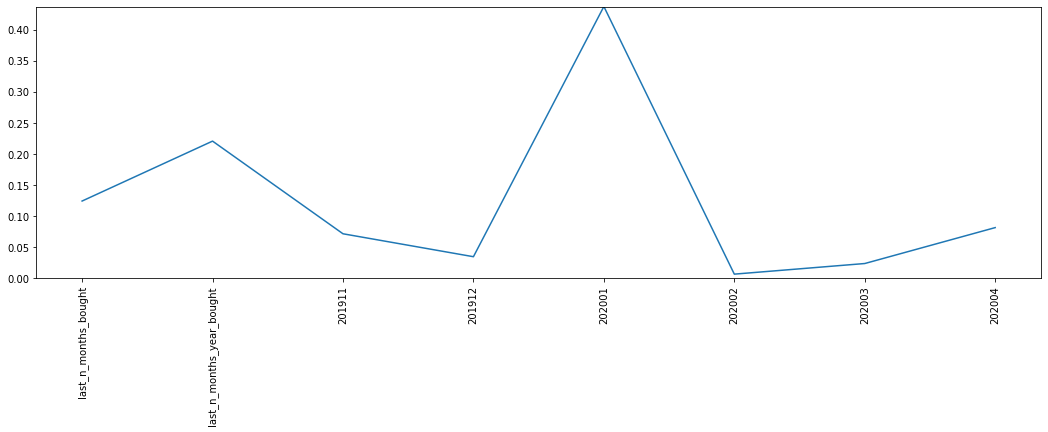

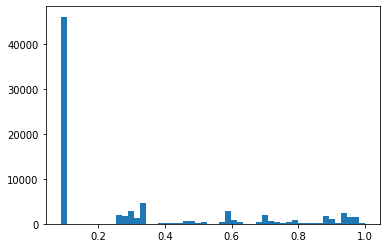

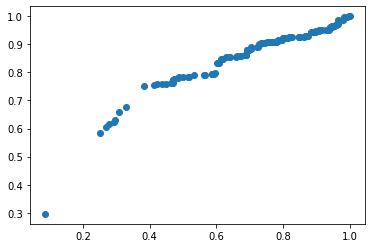

In [ ]:
product = 'D-E'
features_customers = ['id','Segmento_consumidor']
features_customers_df = get_features_customers(ds.customers_df,features_customers)

df_transactions_product = get_df_transactions_product(ds.transactions_train_df, product)

data_train_out_campains = get_data_transactions(features_customers_df, df_transactions_product,
                                                list_last_months = list_3_last_months_train, list_last_year_months = list_last_year_3_months_train)
data_test_out_campains  = get_data_transactions(features_customers_df, df_transactions_product, 
                                                list_last_months = list_3_last_months_test, list_last_year_months = list_last_year_3_months_test)

data_train_nas = data_train_out_campains
data_test_nas  = data_test_out_campains

data_train = fill_na_data(data_train_nas)
data_test = fill_na_data(data_test_nas)

mask_train = (df_transactions_product.Periodo < 202005) & (df_transactions_product.Periodo > 201910)
mask_test = (df_transactions_product.Periodo < 202008)  & (df_transactions_product.Periodo > 202001)
months_features_train = get_months_features(df_transactions_product, data_train, mask_train)
months_features_test = get_months_features(df_transactions_product, data_test, mask_test)

data_train = data_train.merge(months_features_train,how='left',on='id')
data_train.drop(columns='segmento_A',inplace = True)
data_test = data_test.merge(months_features_test,how='left',on='id')
data_test.drop(columns='segmento_A',inplace = True)

df_labels = get_labels(df_transactions_product, features_customers_df, list_3_months_labels_train)
X_train = data_train.drop(columns='id')
X_test  = data_test.drop(columns='id')
y = df_labels['labels']
params = {'n_estimators': 100,'max_depth': 35}
model = RandomForestClassifier(n_estimators=params['n_estimators'], max_depth=params['max_depth'])
model.fit(X_train,y)
print('auc in train (do not metric for model)',roc_auc_score(y,model.predict_proba(X_train)[:,1]))

percen = (1-sum(df_labels.labels)/len(df_labels))
q = np.quantile(model.predict_proba(X_test)[:,1], percen) + dic_deltas[product]

predict_proba_train = model.predict_proba(X_train)[:,1]
predict_proba_test  = model.predict_proba(X_test)[:,1]
dic_scores = precision_treshold_based_score(predict_proba_test, predict_proba_train,y)
prec_base = sum(y)/len(y)
ids_entrega.at[:,product] = [dic_scores[x]-prec_base for x in predict_proba_test ]   ###    
#ids_entrega.at[:,product] = model.predict(X_test)

y_pred = model.predict(X_train)
print('proporcion true 1',sum(df_labels.labels)/len(df_labels))
print('proporcion prediccion', sum(ids_entrega[product]>+dic_epsilons_1[product])/len(ids_entrega))
print('acurracy in  train ',accuracy_score(y,y_pred))
print('precision in  train ',precision_score(y,y_pred))
print('***********************************************************************************')
print('***********************************************************************************')
plt.figure(figsize=(18,5))
plt.plot(model.feature_importances_)
plt.xticks(ticks=range(len(model.feature_importances_)),labels=list(X_train.columns),rotation = 90)
plt.ylim(0,max(model.feature_importances_))
plt.show()
plt.hist(model.predict_proba(X_train)[:,1],bins=50)
plt.show()
plt.scatter(x=list(dic_scores.keys()),y=list(dic_scores.values()))

### Model E-E

auc in train (do not metric for model) 0.8666099145489803
proporcion true 1 0.07006625680483788
proporcion prediccion 0.08593268710946832
acurracy in  train  0.9509800223789587
precision in  train  0.8478802992518704
***********************************************************************************
***********************************************************************************


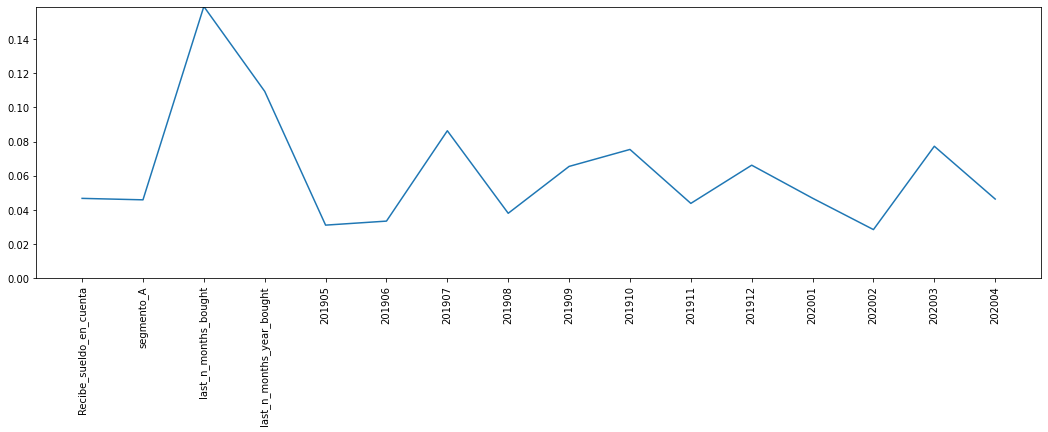

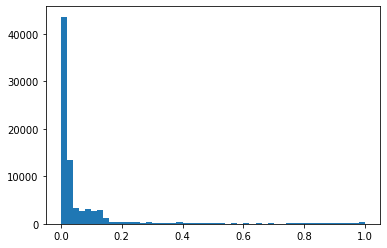

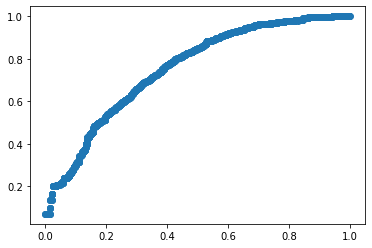

In [ ]:
product = 'E-E'
features_customers = ['id','Segmento_consumidor','Recibe_sueldo_en_cuenta']
features_customers_df = get_features_customers(ds.customers_df,features_customers)

df_transactions_product = get_df_transactions_product(ds.transactions_train_df, product)

data_train_out_campains = get_data_transactions(features_customers_df, df_transactions_product,
                                                list_last_months = list_3_last_months_train, list_last_year_months = list_last_year_3_months_train)
data_test_out_campains  = get_data_transactions(features_customers_df, df_transactions_product, 
                                                list_last_months = list_3_last_months_test, list_last_year_months = list_last_year_3_months_test)

data_train_nas = data_train_out_campains
data_test_nas  = data_test_out_campains

data_train = fill_na_data(data_train_nas)
data_test = fill_na_data(data_test_nas)

mask_train = (df_transactions_product.Periodo < 202005) & (df_transactions_product.Periodo > 201904)
mask_test = (df_transactions_product.Periodo < 202008)  & (df_transactions_product.Periodo > 201907)
months_features_train = get_months_features(df_transactions_product, data_train, mask_train)
months_features_test = get_months_features(df_transactions_product, data_test, mask_test)

data_train = data_train.merge(months_features_train,how='left',on='id')
data_test = data_test.merge(months_features_test,how='left',on='id')

df_labels = get_labels(df_transactions_product, features_customers_df, list_3_months_labels_train)
X_train = data_train.drop(columns='id')
X_test  = data_test.drop(columns='id')
y = df_labels['labels']
params = {'n_estimators': 100,'max_depth': 35}
model = RandomForestClassifier(n_estimators=params['n_estimators'], max_depth=params['max_depth'])
model.fit(X_train,y)
print('auc in train (do not metric for model)',roc_auc_score(y,model.predict_proba(X_train)[:,1]))

percen = (1-sum(df_labels.labels)/len(df_labels))
q = np.quantile(model.predict_proba(X_test)[:,1], percen) + dic_deltas[product]

predict_proba_train = model.predict_proba(X_train)[:,1]
predict_proba_test  = model.predict_proba(X_test)[:,1]
dic_scores = precision_treshold_based_score(predict_proba_test, predict_proba_train,y)
prec_base = sum(y)/len(y)
ids_entrega.at[:,product] = [dic_scores[x]-prec_base for x in predict_proba_test ]   ###  
#ids_entrega.at[:,product] = model.predict(X_test)

y_pred = model.predict(X_train)
print('proporcion true 1',sum(df_labels.labels)/len(df_labels))
print('proporcion prediccion', sum(ids_entrega[product]>dic_epsilons_1[product])/len(ids_entrega))
print('acurracy in  train ',accuracy_score(y, y_pred))
print('precision in  train ',precision_score(y, y_pred))
print('***********************************************************************************')
print('***********************************************************************************')
plt.figure(figsize=(18,5))
plt.plot(model.feature_importances_)
plt.xticks(ticks=range(len(model.feature_importances_)),labels=list(X_train.columns),rotation = 90)
plt.ylim(0,max(model.feature_importances_))
plt.show()
plt.hist(model.predict_proba(X_train)[:,1],bins=50)
plt.show()
plt.scatter(x=list(dic_scores.keys()),y=list(dic_scores.values()))

# with comunications

## Functions version 2

In [12]:
def get_features_customers(customers_df,features_customers):
  features_customers_df = customers_df[features_customers].copy()
  if 'Meses_antiguedad' in  features_customers_df.columns:
    features_customers_df.at[:,'antiquity_1_year'] = [(not (x == 'Menos de 1 año'))*1 for x in features_customers_df.Meses_antiguedad ]
  features_customers_df.at[:,'segmento_A'] =[(x=='A')*1 for x in features_customers_df.Segmento_consumidor]
  cols = ['Segmento_consumidor']
  cols = cols + ['Meses_antiguedad'] if 'Meses_antiguedad' in  features_customers_df.columns else cols
  features_customers_df.drop(columns= cols,inplace=True)
  return features_customers_df

def get_dummies_principalidad(features_customers_df_o):
  features_customers_df = features_customers_df_o.copy()
  features_customers_df = features_customers_df.astype({'Principalidad':'object'})
  features_customers_df.Principalidad.fillna('N',inplace=True)
  principalidad_dummies = pd.get_dummies(features_customers_df.set_index('id').Principalidad,prefix='Prin_')
  return principalidad_dummies
  
def get_months_features(df_transactions_product, data_id, mask):
  months_features = pd.pivot_table(df_transactions_product[mask],index='id',values='Monto',columns='Periodo',fill_value=0)
  months_features = (months_features!=0)*1
  ids_months = pd.DataFrame(data = data_test.id)
  months_features = ids_months.merge(months_features.reset_index(),how ='left', on ='id')
  months_features.fillna(0,inplace=True)
  return months_features

def get_info_months(df_transactions_product, list_months, previous_months = True):
  mask_last =  df_transactions_product["Periodo"].apply(lambda x: x in list_months)
  df_last = pd.DataFrame(data = list(df_transactions_product[mask_last].id.unique()), columns = ['id'])
  name_col = 'last_n_months_bought' if previous_months else 'last_n_months_year_bought'
  df_last.at[:, name_col] = 1
  return df_last

def get_data_transactions(features_customers_df, df_transactions_product, list_last_months =[], list_last_year_months=[]):
  if (list_last_months == []) and (list_last_year_months != []):
    df_last_months_year = get_info_months(df_transactions_product, list_last_year_months, previous_months= False)
    data_transactions = features_customers_df.merge(df_last_months_year, how='left',on='id')
  elif (list_last_months != []) and (list_last_year_months == []):
    df_last_months = get_info_months(df_transactions_product, list_last_months, previous_months= False)
    data_transactions = features_customers_df.merge(df_last_months, how='left',on='id')
  elif (list_last_months != []) and (list_last_year_months != []):
    df_last_months = get_info_months(df_transactions_product, list_last_months)
    df_last_months_year = get_info_months(df_transactions_product, list_last_year_months, previous_months= False)
    data_transactions = features_customers_df.merge(df_last_months, how='left',on='id')
    data_transactions = data_transactions.merge(df_last_months_year, how='left',on='id')
  return data_transactions

def get_df_transactions_product(transactions_df_o, product):
  mask_product = (transactions_df_o["Producto-Tipo"] == product)
  df_transactions_product = transactions_df_o[mask_product].copy()
  return df_transactions_product

def get_data_campains(campains_df, data_out_campains, list_3_months, product):
  mask_campain_product = (campains_df["Producto-Tipo"] == product)
  mask_campain_duration = (campains_df["Duracion_Campaña"]  < 3)
  campain_product_df = campains_df[(mask_campain_product & mask_campain_duration)].copy()
  mask_campains_period =  campain_product_df["Periodo"].apply(lambda x: x in list_3_months)
  df_campains = pd.DataFrame(data = list(campain_product_df[mask_campains_period].id.unique()), columns = ['id'])
  df_campains.at[:,'campain'] = 1
  data = data_out_campains.merge(df_campains, how='left',on='id')
  return data

def get_data_comunications(comunications_df, data_out_comunications, product, list_months):
  mask_comunications = (comunications_df.Periodo.apply(lambda x: x in list_months)) & (comunications_df['Producto-Tipo']==product)
  comunications = comunications_df[mask_comunications].copy()
  comunications = comunications[['id','Lectura']]
  comunications = comunications.astype({'Lectura': 'int64','id':'object'})
  comunications = comunications.groupby('id').agg({'Lectura':'max'}).reset_index()
  comunications.at[:,'Comunication'] = [1]*len(comunications)
  data = data_out_comunications.merge(comunications, how='left', on='id')
  return data

def get_labels(df_transactions_product, features_customers_df, list_3_months_labels_train):
  mask_labels =  df_transactions_product["Periodo"].apply(lambda x: x in list_3_months_labels_train)
  df_labels = pd.DataFrame(data = list(df_transactions_product[mask_labels].id.unique()), columns = ['id'])
  df_labels.at[:,'labels'] = 1
  ids_df = pd.DataFrame(features_customers_df.id)
  df_labels = ids_df.merge(df_labels, how='left', on = 'id')
  df_labels.labels.fillna(0,inplace=True)
  return df_labels

def fill_na_data(data_o):
  data = data_o.copy()
  if 'last_n_months_bought' in data.columns:
    data.last_n_months_bought.fillna(0,inplace=True)
  if 'last_n_months_year_bought' in data.columns:
    data.last_n_months_year_bought.fillna(0,inplace=True)
  if 'campain' in data.columns:
    data.campain.fillna(0,inplace=True)
  if 'Lectura' in data.columns:
    data.Lectura.fillna(0,inplace=True)
  if 'Comunication' in data.columns:
    data.Comunication.fillna(0,inplace=True)
  return data

def precision_treshold_based_score(proba_test, pred_proba,y):
  dic_scores = {}
  for p in pd.Series(proba_test).unique():
    y_pred_tre = ((pred_proba>=p)*1)
    if sum(y_pred_tre)==0:
      dic_scores[p] = 1
    else:
      dic_scores[p] = precision_score(y,y_pred_tre)
  return dic_scores

## Random Forest model

In [21]:
list_3_months_labels_train = [202005,202006,202007]
list_3_last_months_train = [202002,202003,202004]
list_last_year_3_months_train = [201905,201906,201907]

list_3_months_campain_test = [202008,202009,202010]
list_3_last_months_test = [202005,202006,202007]
list_last_year_3_months_test = [201908,201909,201910]

list_months_comunication_train = [202005,202006,202007]
list_months_comunication_test = [202008,202009,202010]

products  = ["A-A", "B-B", "C-D", "D-E", "E-E"]

dic_deltas = {"A-A":0.05, "B-B":0.03, "C-D":0.03, "D-E":0.09, "E-E":0.01}
dic_epsilons_1 = {"A-A":0.3, "B-B":0.2, "C-D":0.5, "D-E":0.1, "E-E":0.4}
dic_epsilons_0 = {"A-A":0.1, "B-B":0.2, "C-D":0.5, "D-E":0.4, "E-E":0.3}


dic_propor_train = {'A-A': 0.022391531198531538, 'B-B': 0.08969184928148455, 'C-D':0.20674134701215754,
                      'D-E': 0.2960937401777744, 'E-E' :0.07006625680483788}

### Model A-A

auc in train (do not metric for model) 0.812700676781224
proporcion true 1 0.022391531198531538
proporcion prediccion 0.014332591558857919
acurracy in  train  0.978664554495279
precision in  train  0.868421052631579
***********************************************************************************
***********************************************************************************


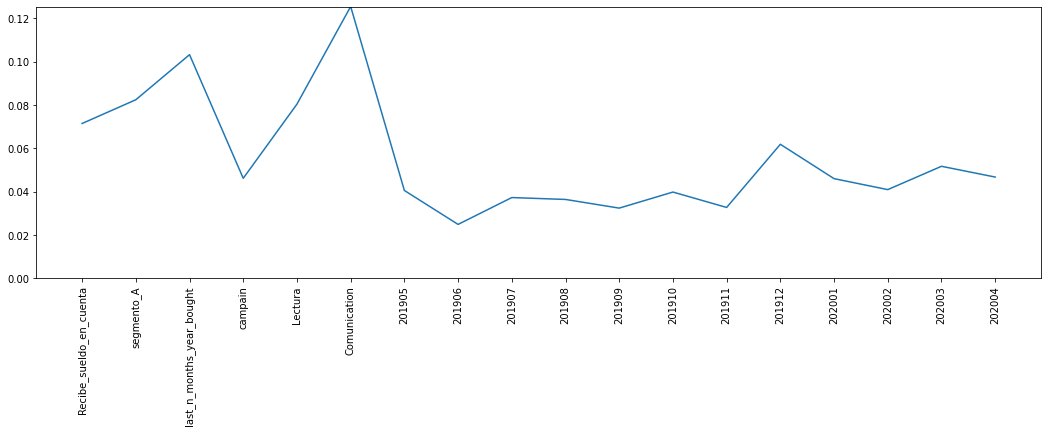

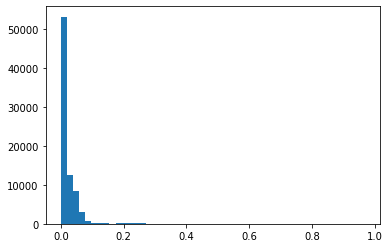

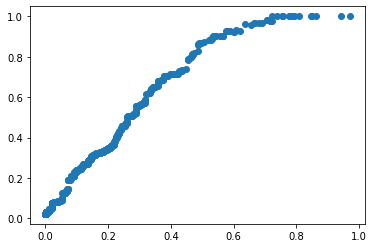

In [45]:

############## Model for A-A ############################################
product = 'A-A'
features_customers = ['id','Segmento_consumidor','Recibe_sueldo_en_cuenta']
features_customers_df = get_features_customers(ds.customers_df,features_customers)

df_transactions_product = get_df_transactions_product(ds.transactions_train_df, product)

data_train_out_campains = get_data_transactions(features_customers_df, df_transactions_product, list_last_months = list_3_last_months_train)
data_test_out_campains  = get_data_transactions(features_customers_df, df_transactions_product, list_last_months = list_3_last_months_test)

data_train_nas = get_data_campains(ds.campains_train_df, data_train_out_campains, list_3_months_labels_train, product)
data_test_nas  = get_data_campains(ds.campains_test_df, data_test_out_campains, list_3_months_campain_test, product)

data_train_nas = get_data_comunications(ds.comunications_train_df, data_train_nas, product, list_months_comunication_train)
data_test_nas  = get_data_comunications(ds.comunications_test_df, data_test_nas, product, list_months_comunication_test)

data_train = fill_na_data(data_train_nas)
data_test = fill_na_data(data_test_nas)

mask_train = (df_transactions_product.Periodo < 202005) & (df_transactions_product.Periodo > 201904)
mask_test = (df_transactions_product.Periodo < 202008)  & (df_transactions_product.Periodo > 201907)
months_features_train = get_months_features(df_transactions_product, data_train, mask_train)
months_features_test = get_months_features(df_transactions_product, data_test, mask_test)

data_train = data_train.merge(months_features_train,how='left',on='id')
data_test = data_test.merge(months_features_test,how='left',on='id')

df_labels = get_labels(df_transactions_product, features_customers_df, list_3_months_labels_train)
X_train = data_train.drop(columns='id')
X_test  = data_test.drop(columns='id')
y = df_labels['labels']
params = {'n_estimators': 100,'max_depth': 35}
model = RandomForestClassifier(n_estimators=params['n_estimators'], max_depth=params['max_depth'])
model.fit(X_train,y)
print('auc in train (do not metric for model)',roc_auc_score(y,model.predict_proba(X_train)[:,1]))



ids_entrega = pd.DataFrame(data = data_test.id)                    ################## only in A-A delete in others

predict_proba_train = model.predict_proba(X_train)[:,1]
predict_proba_test  = model.predict_proba(X_test)[:,1]
dic_scores = precision_treshold_based_score(predict_proba_test, predict_proba_train,y)


ids_entrega.at[:,product] = [dic_scores[x] for x in predict_proba_test ]   ###-prec_base  

y_pred = model.predict(X_train)

print('proporcion true 1',sum(df_labels.labels)/len(df_labels))
print('proporcion prediccion', sum(ids_entrega[product]>dic_epsilons_1[product])/len(ids_entrega))
print('acurracy in  train ',accuracy_score(y,y_pred))
print('precision in  train ',precision_score(y,y_pred))
print('***********************************************************************************')
print('***********************************************************************************')
plt.figure(figsize=(18,5))
plt.plot(model.feature_importances_)
plt.xticks(ticks=range(len(model.feature_importances_)),labels=list(X_train.columns),rotation = 90)
plt.ylim(0,max(model.feature_importances_))
plt.show()
plt.hist(model.predict_proba(X_train)[:,1],bins=50)
plt.show()
plt.scatter(x=list(dic_scores.keys()),y=list(dic_scores.values()))

In [23]:
sum(ids_entrega['A-A']>0.1)   #corte  c y d predeterminado por debajo de 0.1

9128

### Model B-B

auc in train (do not metric for model) 0.6813841613016617
proporcion true 1 0.08969184928148455
proporcion prediccion 0.17730924452155547
acurracy in  train  0.9134764077999472
precision in  train  0.86
***********************************************************************************
***********************************************************************************


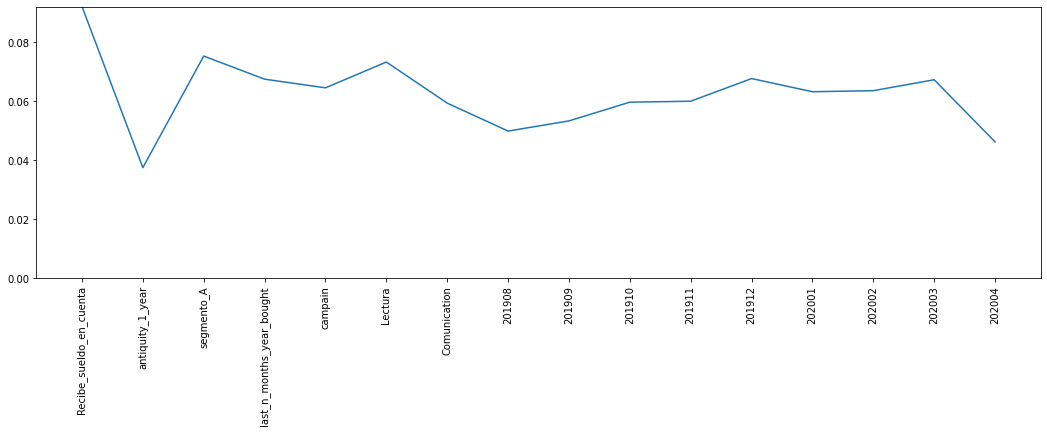

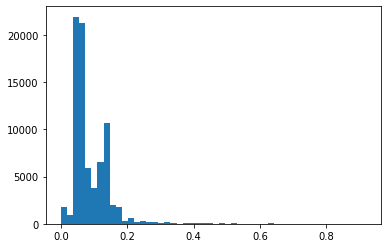

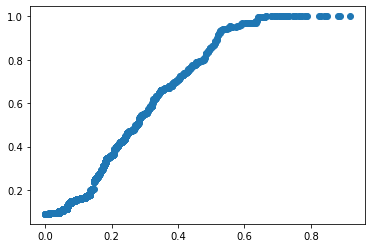

In [24]:
product = 'B-B'
features_customers = ['id','Segmento_consumidor','Recibe_sueldo_en_cuenta','Meses_antiguedad']
features_customers_df = get_features_customers(ds.customers_df,features_customers)

df_transactions_product = get_df_transactions_product(ds.transactions_train_df, product)

data_train_out_campains = get_data_transactions(features_customers_df, df_transactions_product, list_last_year_months = list_last_year_3_months_train)
data_test_out_campains  = get_data_transactions(features_customers_df, df_transactions_product, list_last_year_months = list_last_year_3_months_test)

data_train_nas = get_data_campains(ds.campains_train_df, data_train_out_campains, list_3_months_labels_train, product)
data_test_nas  = get_data_campains(ds.campains_test_df, data_test_out_campains, list_3_months_campain_test, product)

data_train_nas = get_data_comunications(ds.comunications_train_df, data_train_nas, product, list_months_comunication_train)
data_test_nas  = get_data_comunications(ds.comunications_test_df, data_test_nas, product, list_months_comunication_test)

data_train = fill_na_data(data_train_nas)
data_test = fill_na_data(data_test_nas)

mask_train = (df_transactions_product.Periodo < 202005) & (df_transactions_product.Periodo > 201907)
mask_test = (df_transactions_product.Periodo < 202008)  & (df_transactions_product.Periodo > 201910)
months_features_train = get_months_features(df_transactions_product, data_train, mask_train)
months_features_test = get_months_features(df_transactions_product, data_test, mask_test)

data_train = data_train.merge(months_features_train,how='left',on='id')
data_test = data_test.merge(months_features_test,how='left',on='id')

df_labels = get_labels(df_transactions_product, features_customers_df, list_3_months_labels_train)
X_train = data_train.drop(columns='id')
X_test  = data_test.drop(columns='id')
y = df_labels['labels']
params = {'n_estimators': 100,'max_depth': 35}
model = RandomForestClassifier(n_estimators=params['n_estimators'], max_depth=params['max_depth'])
model.fit(X_train,y)
print('auc in train (do not metric for model)',roc_auc_score(y,model.predict_proba(X_train)[:,1]))


predict_proba_train = model.predict_proba(X_train)[:,1]
predict_proba_test  = model.predict_proba(X_test)[:,1]
dic_scores = precision_treshold_based_score(predict_proba_test, predict_proba_train,y)

ids_entrega.at[:,product] = [dic_scores[x] for x in predict_proba_test ]   ###-prec_base  

#ids_entrega.at[:,product] = model.predict(X_test)

y_pred = model.predict(X_train)
print('proporcion true 1',sum(df_labels.labels)/len(df_labels))
print('proporcion prediccion', sum(ids_entrega[product]>dic_epsilons_1[product])/len(ids_entrega))
print('acurracy in  train ',accuracy_score(y,y_pred))
print('precision in  train ',precision_score(y,y_pred))
print('***********************************************************************************')
print('***********************************************************************************')
plt.figure(figsize=(18,5))
plt.plot(model.feature_importances_)
plt.xticks(ticks=range(len(model.feature_importances_)),labels=list(X_train.columns),rotation = 90)
plt.ylim(0,max(model.feature_importances_))
plt.show()
plt.hist(model.predict_proba(X_train)[:,1],bins=50)
plt.show()
plt.scatter(x=list(dic_scores.keys()),y=list(dic_scores.values()))

In [25]:
sum(ids_entrega['B-B'] > 0.2)   #corte  c y d predeterminado por debajo de 0.1

14103

In [72]:

ids_entrega['A-A'] = ids_entrega['A-A'] - 0.033


KeyError: ignored

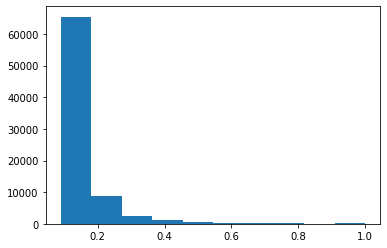

In [26]:
plt.hist(ids_entrega['B-B'],label='B-B')
plt.hist(ids_entrega['E-E'],label='E-E')
plt.hist(ids_entrega['A-A'],label='A-A')
plt.legend()

In [331]:
print(sum(ids_entrega['A-A']>0))   # restar 0.033
print(sum(ids_entrega['B-B']>0))  # restar 0.11
print(sum(ids_entrega['E-E']>0)) # restar 0.075

49654
47209
51933


In [69]:
ids_entrega['C-D'] = send_c
ids_entrega['D-E'] = send_d
ids_entrega['B-B'] = send_b
ids_entrega['E-E'] = send_e

In [318]:
entrega_df['productos'] = [" ".join(x) for x in entrega_df["variable"]]

### Model D-E No model

auc in train (do not metric for model) 0.8526803075446265
proporcion true 1 0.2960937401777744
proporcion prediccion 0.44618363318623566
acurracy in  train  0.8398521480028666
precision in  train  0.7838802835389866
***********************************************************************************
***********************************************************************************


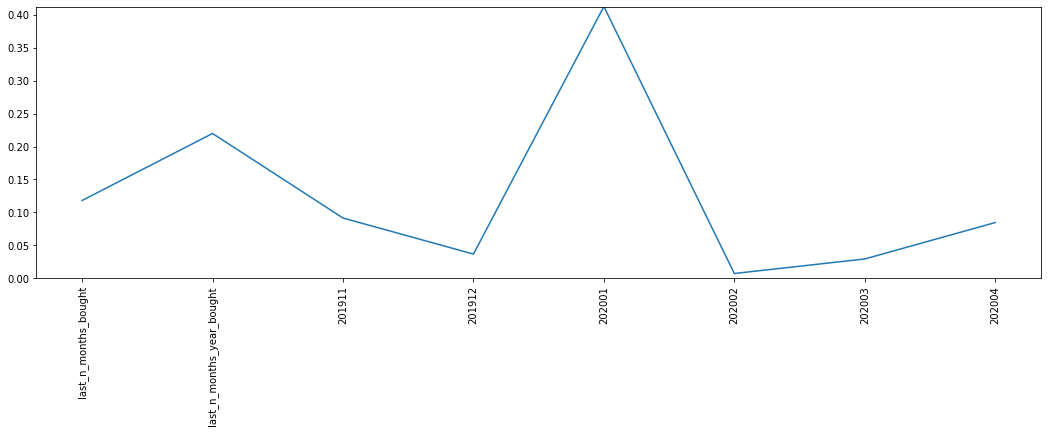

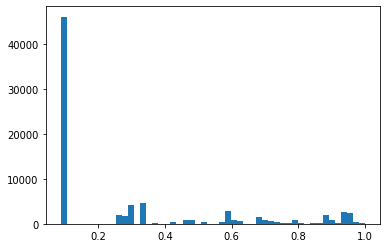

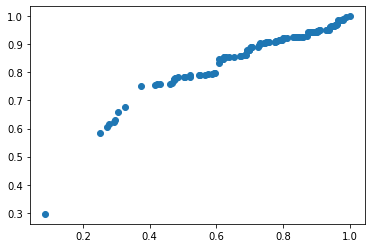

In [ ]:
product = 'D-E'
features_customers = ['id','Segmento_consumidor']
features_customers_df = get_features_customers(ds.customers_df,features_customers)

df_transactions_product = get_df_transactions_product(ds.transactions_train_df, product)

data_train_out_campains = get_data_transactions(features_customers_df, df_transactions_product,
                                                list_last_months = list_3_last_months_train, list_last_year_months = list_last_year_3_months_train)
data_test_out_campains  = get_data_transactions(features_customers_df, df_transactions_product, 
                                                list_last_months = list_3_last_months_test, list_last_year_months = list_last_year_3_months_test)

data_train_nas = data_train_out_campains
data_test_nas  = data_test_out_campains

#data_train_nas = get_data_comunications(ds.comunications_train_df, data_train_nas, product, list_months_comunication_train)
#data_test_nas  = get_data_comunications(ds.comunications_test_df, data_test_nas, product, list_months_comunication_test)

data_train = fill_na_data(data_train_nas)
data_test = fill_na_data(data_test_nas)

mask_train = (df_transactions_product.Periodo < 202005) & (df_transactions_product.Periodo > 201910)
mask_test = (df_transactions_product.Periodo < 202008)  & (df_transactions_product.Periodo > 202001)
months_features_train = get_months_features(df_transactions_product, data_train, mask_train)
months_features_test = get_months_features(df_transactions_product, data_test, mask_test)

data_train = data_train.merge(months_features_train,how='left',on='id')
data_train.drop(columns='segmento_A',inplace = True)
data_test = data_test.merge(months_features_test,how='left',on='id')
data_test.drop(columns='segmento_A',inplace = True)

df_labels = get_labels(df_transactions_product, features_customers_df, list_3_months_labels_train)
X_train = data_train.drop(columns='id')
X_test  = data_test.drop(columns='id')
y = df_labels['labels']
params = {'n_estimators': 100,'max_depth': 35}
model = RandomForestClassifier(n_estimators=params['n_estimators'], max_depth=params['max_depth'])
model.fit(X_train,y)
print('auc in train (do not metric for model)',roc_auc_score(y,model.predict_proba(X_train)[:,1]))



predict_proba_train = model.predict_proba(X_train)[:,1]
predict_proba_test  = model.predict_proba(X_test)[:,1]
dic_scores = precision_treshold_based_score(predict_proba_test, predict_proba_train,y)


ids_entrega.at[:,product] = [dic_scores[x] for x in predict_proba_test ]   ###-prec_base  
percen = dic_propor_train[product]/sum(dic_propor_train.values())
prec_base = sum(y)/len(y)
q = 0.35
ids_entrega.at[:,product] = ids_entrega.loc[:,product] - q

#ids_entrega.at[:,product] = model.predict(X_test)

y_pred = model.predict(X_train)
print('proporcion true 1',sum(df_labels.labels)/len(df_labels))
print('proporcion prediccion', sum(ids_entrega[product]>+dic_epsilons_1[product])/len(ids_entrega))
print('acurracy in  train ',accuracy_score(y,y_pred))
print('precision in  train ',precision_score(y,y_pred))
print('***********************************************************************************')
print('***********************************************************************************')
plt.figure(figsize=(18,5))
plt.plot(model.feature_importances_)
plt.xticks(ticks=range(len(model.feature_importances_)),labels=list(X_train.columns),rotation = 90)
plt.ylim(0,max(model.feature_importances_))
plt.show()
plt.hist(model.predict_proba(X_train)[:,1],bins=50)
plt.show()
plt.scatter(x=list(dic_scores.keys()),y=list(dic_scores.values()))

### Model E-E

auc in train (do not metric for model) 0.8666464345461726
proporcion true 1 0.07006625680483788
proporcion prediccion 0.10510567143162473
acurracy in  train  0.9509674499302229
precision in  train  0.8449484536082474
***********************************************************************************
***********************************************************************************


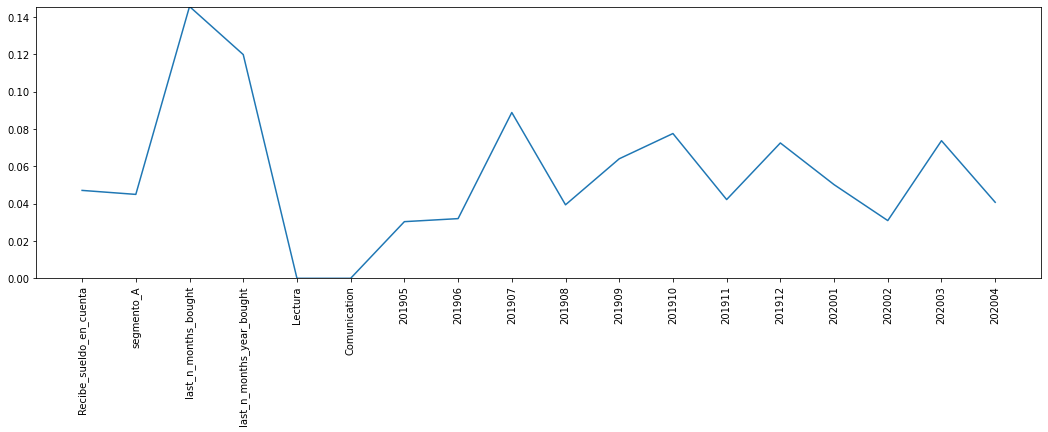

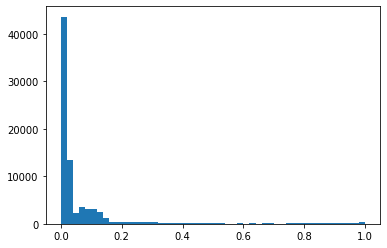

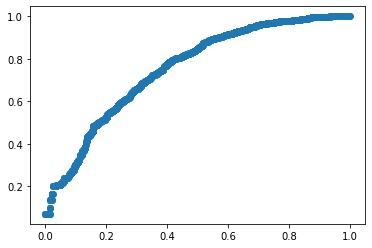

In [30]:
product = 'E-E'
features_customers = ['id','Segmento_consumidor','Recibe_sueldo_en_cuenta']
features_customers_df = get_features_customers(ds.customers_df,features_customers)

df_transactions_product = get_df_transactions_product(ds.transactions_train_df, product)

data_train_out_campains = get_data_transactions(features_customers_df, df_transactions_product,
                                                list_last_months = list_3_last_months_train, list_last_year_months = list_last_year_3_months_train)
data_test_out_campains  = get_data_transactions(features_customers_df, df_transactions_product, 
                                                list_last_months = list_3_last_months_test, list_last_year_months = list_last_year_3_months_test)

data_train_nas = data_train_out_campains
data_test_nas  = data_test_out_campains

data_train_nas = get_data_comunications(ds.comunications_train_df, data_train_nas, product, list_months_comunication_train)
data_test_nas  = get_data_comunications(ds.comunications_test_df, data_test_nas, product, list_months_comunication_test)

data_train = fill_na_data(data_train_nas)
data_test = fill_na_data(data_test_nas)

mask_train = (df_transactions_product.Periodo < 202005) & (df_transactions_product.Periodo > 201904)
mask_test = (df_transactions_product.Periodo < 202008)  & (df_transactions_product.Periodo > 201907)
months_features_train = get_months_features(df_transactions_product, data_train, mask_train)
months_features_test = get_months_features(df_transactions_product, data_test, mask_test)

data_train = data_train.merge(months_features_train,how='left',on='id')
data_test = data_test.merge(months_features_test,how='left',on='id')

df_labels = get_labels(df_transactions_product, features_customers_df, list_3_months_labels_train)
X_train = data_train.drop(columns='id')
X_test  = data_test.drop(columns='id')
y = df_labels['labels']
params = {'n_estimators': 100,'max_depth': 35}
model = RandomForestClassifier(n_estimators=params['n_estimators'], max_depth=params['max_depth'])
model.fit(X_train,y)
print('auc in train (do not metric for model)',roc_auc_score(y,model.predict_proba(X_train)[:,1]))



predict_proba_train = model.predict_proba(X_train)[:,1]
predict_proba_test  = model.predict_proba(X_test)[:,1]
dic_scores = precision_treshold_based_score(predict_proba_test, predict_proba_train,y)

ids_entrega.at[:,product] = [dic_scores[x] for x in predict_proba_test ]   ###-prec_base  


#ids_entrega.at[:,product] = model.predict(X_test)

y_pred = model.predict(X_train)
print('proporcion true 1',sum(df_labels.labels)/len(df_labels))
print('proporcion prediccion', sum(ids_entrega[product]>dic_epsilons_1[product])/len(ids_entrega))
print('acurracy in  train ',accuracy_score(y, y_pred))
print('precision in  train ',precision_score(y, y_pred))
print('***********************************************************************************')
print('***********************************************************************************')
plt.figure(figsize=(18,5))
plt.plot(model.feature_importances_)
plt.xticks(ticks=range(len(model.feature_importances_)),labels=list(X_train.columns),rotation = 90)
plt.ylim(0,max(model.feature_importances_))
plt.show()
plt.hist(model.predict_proba(X_train)[:,1],bins=50)
plt.show()
plt.scatter(x=list(dic_scores.keys()),y=list(dic_scores.values()))

### Model C-D No model

auc in train (do not metric for model) 0.9274324716704755
proporcion true 1 0.20674134701215754
proporcion prediccion 0.22054589572411018
acurracy in  train  0.9492450244534127
precision in  train  0.9133186754613898
***********************************************************************************
***********************************************************************************


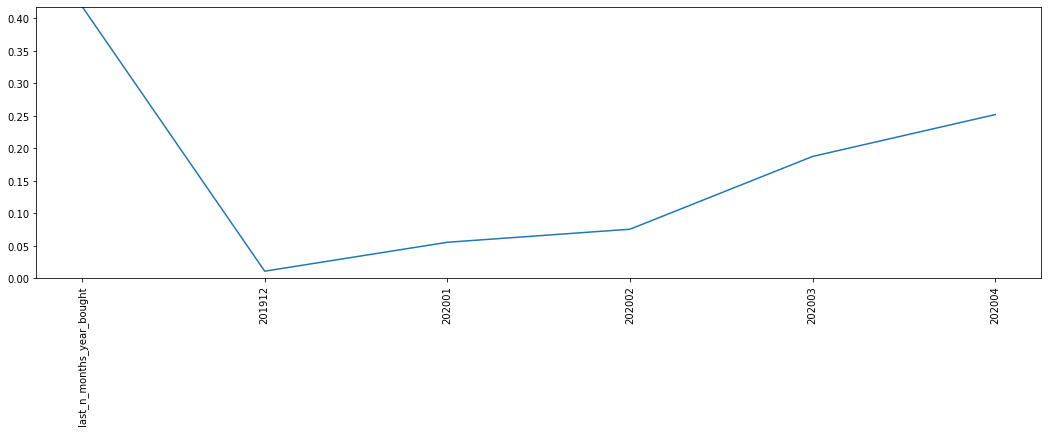

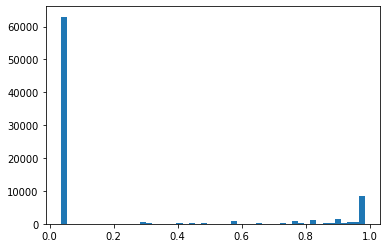

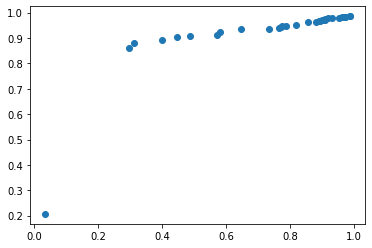

In [ ]:
product = 'C-D'
features_customers = ['id','Segmento_consumidor']
features_customers_df = get_features_customers(ds.customers_df,features_customers)

df_transactions_product = get_df_transactions_product(ds.transactions_train_df, product)

data_train_out_campains = get_data_transactions(features_customers_df, df_transactions_product, list_last_months = list_3_last_months_train)
data_test_out_campains  = get_data_transactions(features_customers_df, df_transactions_product, list_last_months = list_3_last_months_test)

#data_train_nas = get_data_campains(ds.campains_train_df, data_train_out_campains, list_3_months_labels_train, product)
#data_test_nas  = get_data_campains(ds.campains_test_df, data_test_out_campains, list_3_months_campain_test, product)

#data_train_nas = get_data_comunications(ds.comunications_train_df, data_train_nas, product, list_months_comunication_train)
#data_test_nas  = get_data_comunications(ds.comunications_test_df, data_test_nas, product, list_months_comunication_test)

data_train_nas = data_train_out_campains
data_test_nas  = data_test_out_campains

data_train = fill_na_data(data_train_nas)
data_test = fill_na_data(data_test_nas)

mask_train = (df_transactions_product.Periodo < 202005) & (df_transactions_product.Periodo > 201911)
mask_test = (df_transactions_product.Periodo < 202008)  & (df_transactions_product.Periodo > 202002)
months_features_train = get_months_features(df_transactions_product, data_train, mask_train)
months_features_test = get_months_features(df_transactions_product, data_test, mask_test)

data_train = data_train.merge(months_features_train,how='left',on='id')
data_train.drop(columns='segmento_A',inplace = True)
data_test = data_test.merge(months_features_test,how='left',on='id')
data_test.drop(columns='segmento_A',inplace = True)

df_labels = get_labels(df_transactions_product, features_customers_df, list_3_months_labels_train)
X_train = data_train.drop(columns='id')
X_test  = data_test.drop(columns='id')
y = df_labels['labels']
params = {'n_estimators': 100,'max_depth': 35}
model = RandomForestClassifier(n_estimators=params['n_estimators'], max_depth=params['max_depth'])
model.fit(X_train,y)
print('auc in train (do not metric for model)',roc_auc_score(y,model.predict_proba(X_train)[:,1]))



predict_proba_train = model.predict_proba(X_train)[:,1]
predict_proba_test  = model.predict_proba(X_test)[:,1]
dic_scores = precision_treshold_based_score(predict_proba_test, predict_proba_train,y)

ids_entrega.at[:,product] = [dic_scores[x] for x in predict_proba_test ]   ###-prec_base  
percen = dic_propor_train[product]/sum(dic_propor_train.values())
prec_base = sum(y)/len(y)
q = 0.28
ids_entrega.at[:,product] = ids_entrega.loc[:,product] - q

#ids_entrega.at[:,product] = model.predict(X_test)

y_pred = model.predict(X_train)
print('proporcion true 1',sum(df_labels.labels)/len(df_labels))
print('proporcion prediccion', sum(ids_entrega[product]>dic_epsilons_1[product])/len(ids_entrega))
print('acurracy in  train ',accuracy_score(y,y_pred))
print('precision in  train ',precision_score(y,y_pred))
print('***********************************************************************************')
print('***********************************************************************************')
plt.figure(figsize=(18,5))
plt.plot(model.feature_importances_)
plt.xticks(ticks=range(len(model.feature_importances_)),labels=list(X_train.columns),rotation = 90)
plt.ylim(0,max(model.feature_importances_))
plt.show()
plt.hist(model.predict_proba(X_train)[:,1],bins=50)
plt.show()
plt.scatter(x=list(dic_scores.keys()),y=list(dic_scores.values()))

# Send

In [73]:
#ids_entrega.reset_index(inplace=True)
products  = ["A-A", "B-B", "C-D", "D-E", "E-E"]
entrega_vals = pd.melt(ids_entrega,id_vars='id',value_vars=products)
entrega_vals.sort_values(by=['id','value'], ascending=[True,False],inplace=True)
entrega_df = entrega_vals.groupby('id').agg({'variable':list})
entrega_df['productos'] = [" ".join(x) for x in entrega_df["variable"]]

In [74]:
for i in range(5):
  print('+++++++++++++',i+1,'+++++++++++++')
  primera = pd.Series([lista[i] for lista in entrega_df.variable])
  print(primera.value_counts()/len(primera))
  print('**********************************************************************')

+++++++++++++ 1 +++++++++++++
C-D    0.372509
D-E    0.365418
B-B    0.123424
E-E    0.113466
A-A    0.025183
dtype: float64
**********************************************************************
+++++++++++++ 2 +++++++++++++
C-D    0.284640
D-E    0.282855
B-B    0.216234
E-E    0.125750
A-A    0.090522
dtype: float64
**********************************************************************
+++++++++++++ 3 +++++++++++++
B-B    0.260049
C-D    0.230189
A-A    0.224154
D-E    0.209319
E-E    0.076290
dtype: float64
**********************************************************************
+++++++++++++ 4 +++++++++++++
B-B    0.296333
E-E    0.278631
A-A    0.212625
D-E    0.113416
C-D    0.098995
dtype: float64
**********************************************************************
+++++++++++++ 5 +++++++++++++
A-A    0.447516
E-E    0.405864
B-B    0.103962
D-E    0.028992
C-D    0.013666
dtype: float64
**********************************************************************


In [75]:
from datetime import datetime
entrega_df.drop(columns='variable',inplace=True)
entrega_df
filename = ds.BASE_PATH/f'predictions/{datetime.now().strftime("%Y-%m-%d_%H:%M:%S")}.csv'
entrega_df.to_csv(filename)

In [336]:
entrega_df.head(10)

,productos
id,
1,B-B A-A C-D D-E E-E
2,D-E C-D E-E A-A B-B
3,E-E A-A C-D D-E B-B
4,E-E D-E C-D B-B A-A
5,D-E B-B E-E A-A C-D
6,D-E E-E B-B A-A C-D
7,B-B D-E A-A C-D E-E
8,E-E A-A C-D D-E B-B
9,C-D D-E E-E A-A B-B


# comunicaciones

In [ ]:
ds.comunications_train_df

In [ ]:
product = 'B-B'
list_months_comunication = [202005,202006]
mask_comunications = (ds.comunications_train_df.Periodo.apply(lambda x: x in list_months_comunication )) & (ds.comunications_train_df['Producto-Tipo']==product)
comunications = ds.comunications_train_df[mask_comunications].copy()
comunications = comunications[['id','Lectura']]
comunications.at[:,'comunication'] = 1
comunications

In [ ]:
sum(mask_comunications)

In [ ]:
product = 'B-B'
list_months_comunication = [202009]
mask_comunications = (ds.comunications_test_df.Periodo.apply(lambda x: x in list_months_comunication )) & (ds.comunications_test_df['Producto-Tipo']==product)
comunications = ds.comunications_test_df[mask_comunications].copy()
comunications = comunications[['id','Lectura']]
comunications.at[:,'comunication'] = 1
comunications = comunications.astype({'Lectura': 'int64','id':'object'})
comunications.Lectura.sum()

In [ ]:
comunications = comunications.astype({'Lectura': 'int64','id':'object'})
comunications.Lectura.sum()

In [ ]:
comunications.Lectura.value_counts()

# evaluaciones

In [ ]:
#comunications_df, list_months = ds.comunications_train_df, [202005,202006,202007]
list_months , comunications_df = [202010,202009] ,  ds.comunications_test_df
product = 'B-B'

mask_comunications = (comunications_df.Periodo.apply(lambda x: x in list_months)) & (comunications_df['Producto-Tipo']==product)
comunications = comunications_df[mask_comunications].copy()
comunications = comunications[['id','Lectura']]
comunications = comunications.astype({'Lectura': 'int64','id':'object'})
comunications = comunications.groupby('id').agg({'Lectura':'max'}).reset_index()
comunications.at[:,'Comunication'] = [1]*len(comunications)
print(sum(comunications.Comunication), sum(comunications.Lectura))

60354 35889


******************************************************
A-A 0.2
737


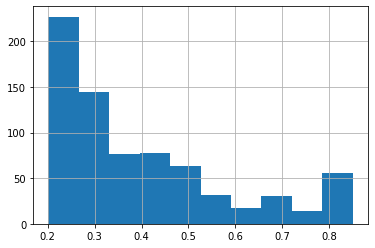

******************************************************
B-B 0.2
1645


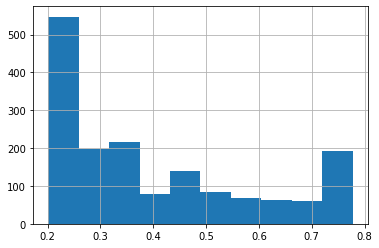

******************************************************
C-D 0.2
17542


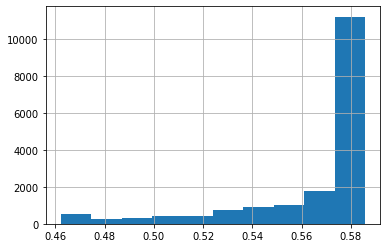

******************************************************
D-E 0.2
35489


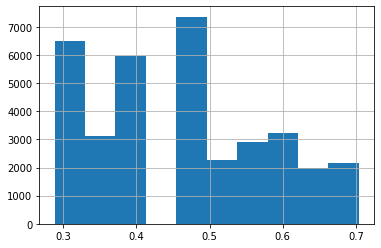

******************************************************
E-E 0.2
4766


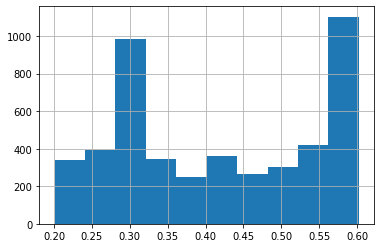

In [ ]:
corte = 0.2
for product in products:
  mask = ids_entrega[product] >= corte
  scores = ids_entrega[mask][product]
  print('******************************************************')
  print(product, corte )
  print(sum(scores.value_counts()))
  scores.hist()
  plt.show()


In [ ]:
dic_propor_train = {'A-A': 0.022391531198531538, 'B-B': 0.08969184928148455, 'C-D':0.20674134701215754,
                      'D-E': 0.2960937401777744, 'E-E' :0.07006625680483788}
product = 'C-D'

In [ ]:
percen = dic_propor_train[product]/sum(dic_propor_train.values())
q = np.quantile(ids_entrega[product],(1- percen))
q

0.20674134701215754

******************************************************
C-D 0.20674134701215754
17542
0.22054589572411018


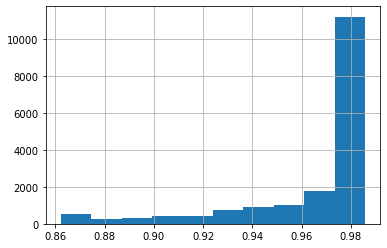

In [ ]:
corte = q
mask = ids_entrega[product] > corte
scores = ids_entrega[mask][product]
print('******************************************************')
print(product, corte )
print(sum(scores.value_counts()))
print(sum(scores.value_counts())/len(ids_entrega))
scores.hist()
plt.show()

In [ ]:
3817/len(ids_entrega)

0.04798903682470235

In [ ]:
ds.customers_df

,Edad,Sexo,Renta,Recibe_sueldo_en_cuenta,Segmento_consumidor,Meses_antiguedad,Comuna,Ciudad,Estado_civil,Principalidad,Profesion,id
0,Mayor a 70,1,R1,0,A,Mayor a 10 años,331.0,13.0,D,B,P164,1
1,Mayor a 70,1,R9,0,B,Mayor a 10 años,37.0,5.0,D,E,P164,2
2,Mayor a 70,1,R9,1,B,Mayor a 10 años,19.0,4.0,B,D,P114,3
3,Mayor a 70,1,R10,0,B,Mayor a 10 años,37.0,5.0,B,C,P164,4
4,Mayor a 70,1,R4,0,A,Mayor a 10 años,91.0,13.0,D,B,P85,5
...,...,...,...,...,...,...,...,...,...,...,...,...
79548,Entre 30 y 35,0,R2,0,A,Menos de 1 año,189.0,8.0,A,NaN,NaN,79535
79549,Entre 35 y 40,0,R1,0,A,Menos de 1 año,72.0,13.0,B,NaN,NaN,79536
79550,Entre 50 y 55,1,R1,0,A,Menos de 1 año,342.0,8.0,B,NaN,NaN,79537
79551,Entre 45 y 50,0,R2,0,A,Menos de 1 año,71.0,13.0,A,NaN,NaN,79538


# evolucion en el tiempo

In [31]:
list_year = [ 201901,201902,201903,201904,201905,201906,201907,201908, 201909, 201910, 201911, 201912, 202001, 202002, 202003, 202004, 202005, 202006, 202007]
dic_df = {'A-A':[], 'B-B':[], 'C-D':[],'D-E':[],'E-E':[],
          '1_prod':[], '2_prod':[], '3_prod':[], '4_prod':[],'5_prod':[]}
for i in range(len(list_year)):
  mask_products = (ds.transactions_train_df['Producto-Tipo'].apply( lambda x: x in products)) & (ds.transactions_train_df.Periodo == list_year[i]) 
  transactions = ds.transactions_train_df[mask_products].copy()
  transactions = transactions.astype({'id':'object', 'Producto-Tipo':'object'})
  transactions = transactions[['id','Periodo','Producto-Tipo']].copy()
  table = pd.pivot_table(data=transactions ,index= 'id', columns='Producto-Tipo', values = 'Periodo', aggfunc= 'count')
  table.fillna(0, inplace=True)
  table = (table>0)*1
  porc_prods = table.sum(axis =0)/len(ds.customers_df)
  table.at[:,'total'] = table.sum(axis =1)
  tab_val_cou = table.total.value_counts()
  for k,product in enumerate(products):
    if i ==6 and product =='E-E':
      dic_df[product].append(0)
    else:
      dic_df[product].append(porc_prods[k])
    j= k+1
    key_pro = str(j)+'_prod'
    if k <len(tab_val_cou):
      dic_df[key_pro].append(tab_val_cou.values[k])
    else:
      dic_df[key_pro].append(0)
  print('ciclo')
df_evolution = pd.DataFrame(dic_df)

ciclo
ciclo
ciclo
ciclo
ciclo
ciclo
ciclo
ciclo
ciclo
ciclo
ciclo
ciclo
ciclo
ciclo
ciclo
ciclo
ciclo
ciclo
ciclo


In [38]:
df_evolution.index = list_year
df_evolution

,A-A,B-B,C-D,D-E,E-E,1_prod,2_prod,3_prod,4_prod,5_prod
201901,0.012271,0.035844,0.130716,0.087316,0.067577,19354,3284,202,4,0
201902,0.009807,0.036397,0.123210,0.050277,0.029495,15900,1813,98,0,0
201903,0.012296,0.103459,0.128113,0.056375,0.067464,20384,3937,319,8,0
201904,0.010737,0.043274,0.130238,0.136587,0.039905,21273,3390,212,1,0
201905,0.009706,0.049799,0.134223,0.119061,0.067904,21991,3762,247,6,0
201906,0.008109,0.048052,0.125989,0.048517,0.038899,16908,2083,121,1,0
201907,0.011101,0.131168,0.141277,0.072744,0.000000,22753,2739,36,0,0
201908,0.011982,0.031972,0.131357,0.128440,0.029533,19994,3077,119,1,0
201909,0.008273,0.039477,0.129559,0.080489,0.067539,19435,3005,144,0,0
201910,0.009769,0.038107,0.128930,0.077270,0.041426,18298,2434,110,2,0


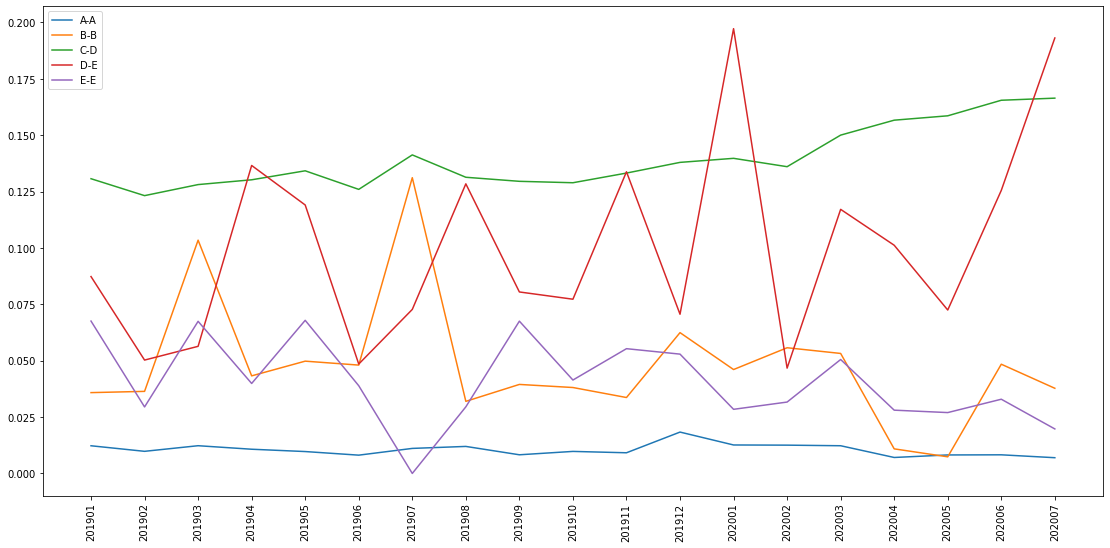

In [44]:
plt.figure(figsize=(19,9))
for product in products:
  plt.plot(df_evolution[product].values, label=product)
plt.xticks(ticks=range(len(list_year)), labels = list_year, rotation = 90)
plt.legend()
plt.show()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]

In [256]:
import seaborn as sns
def product_tendence(product):
  year_in = [201902,201905,201908,201911,202002,202005]
  year_ou = [201905,201908,201911,202002,202005,202008]
  df = pd.DataFrame(ds.customers_df['id'])
  for i in range(len(year_in)):
    transactions = ds.transactions_train_df.astype({'id':'object','Producto-Tipo': 'object'}).copy()
    mask_products = (transactions['Producto-Tipo']==product) & (transactions.Periodo >= year_in[i]) & (transactions.Periodo < year_ou[i]) 
    transactions = transactions[mask_products].copy()
    transactions = pd.DataFrame(transactions['id'].copy())
    col = str(year_in[i])
    transactions.at[:,col] = [1]*len(transactions)
    df = df.merge(transactions, how= 'left', on = 'id')
  df.fillna(0, inplace= True)
  df.set_index('id',inplace=True)
  plt.figure(figsize=(10,5))
  col_year = [str(year) for year in year_in]
  col_year.reverse()
  df.sort_values(by =col_year, inplace=True)
  sns.heatmap(df, cbar = False,yticklabels = False)
  return df

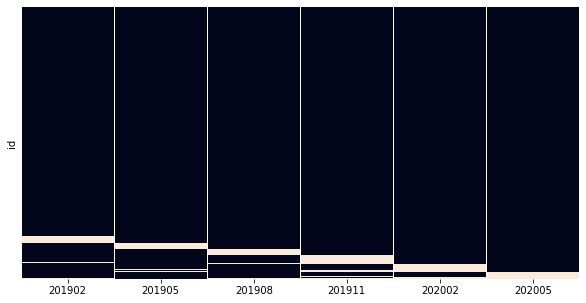

In [10]:
df_a = product_tendence('A-A')

In [46]:
df_b = product_tendence('B-B')

NameError: ignored

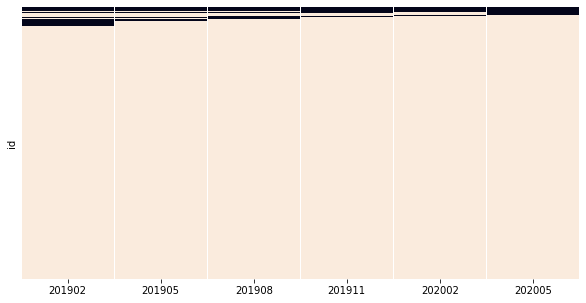

In [257]:
df_c = product_tendence('C-D')

In [258]:
df_c

,201902,201905,201908,201911,202002,202005
id,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
79539,1.0,1.0,1.0,1.0,1.0,1.0
79539,1.0,1.0,1.0,1.0,1.0,1.0
79539,1.0,1.0,1.0,1.0,1.0,1.0


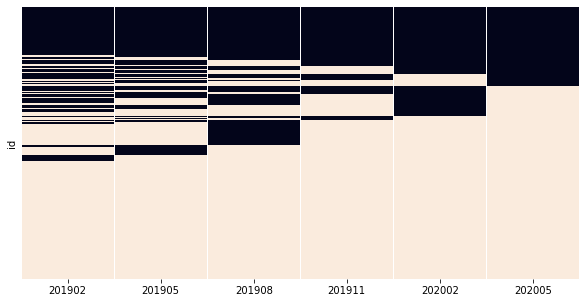

In [13]:
df_d = product_tendence('D-E')

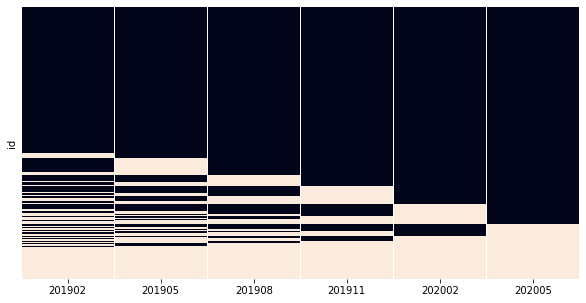

In [14]:
df_e = product_tendence('E-E')

In [15]:
df_a['A-A'] = df_a.sum(axis=1)*1 +0.1
df_b['B-B'] = df_b.sum(axis=1)*2 +0.2
df_c['C-D'] = df_c.sum(axis=1)*5 +0.5
df_d['D-E'] = df_d.sum(axis=1)*4 +0.4
df_e['E-E'] = df_e.sum(axis=1)*3 +0.3

In [16]:
list_df_pred = [df_a['A-A'],df_b['B-B'],df_c['C-D'],df_d['D-E'],df_e['E-E']]
for i , s in enumerate(list_df_pred):
  df_i = pd.DataFrame(s)
  df_i.reset_index(inplace= True)
  df_i.drop_duplicates(inplace =True)
  if i==0:
    df_pred =df_i
  else:
    df_pred = df_pred.merge(df_i,how='outer',on='id')
df_pred

,id,A-A,B-B,C-D,D-E,E-E
0,1,0.1,0.2,0.5,0.4,0.3
1,2,0.1,2.2,20.5,24.4,9.3
2,5,0.1,2.2,0.5,8.4,6.3
3,8,0.1,0.2,0.5,0.4,18.3
4,9,0.1,2.2,30.5,20.4,3.3
...,...,...,...,...,...,...
79534,58077,4.1,4.2,0.5,4.4,6.3
79535,59187,4.1,2.2,30.5,4.4,0.3
79536,65818,4.1,6.2,5.5,12.4,0.3
79537,66020,4.1,0.2,20.5,0.4,9.3


In [17]:
df_pred_melt = pd.melt(df_pred, id_vars = 'id', value_vars=['A-A','B-B','C-D','D-E','E-E'])
df_pred_melt

,id,variable,value
0,1,A-A,0.1
1,2,A-A,0.1
2,5,A-A,0.1
3,8,A-A,0.1
4,9,A-A,0.1
...,...,...,...
397690,58077,E-E,6.3
397691,59187,E-E,0.3
397692,65818,E-E,0.3
397693,66020,E-E,9.3


In [18]:
df_pred_sort = df_pred_melt.sort_values(by = ['id','value'], ascending=[True,False])
df_pred_sort

,id,variable,value
159078,1,C-D,0.5
238617,1,D-E,0.4
318156,1,E-E,0.3
79539,1,B-B,0.2
0,1,A-A,0.1
...,...,...,...
226947,79539,C-D,30.5
386025,79539,E-E,6.3
147408,79539,B-B,2.2
306486,79539,D-E,0.4


In [19]:
entrega = df_pred_sort.groupby('id').agg({'variable':list}).reset_index()
entrega

,id,variable
0,1,"[C-D, D-E, E-E, B-B, A-A]"
1,2,"[D-E, C-D, E-E, B-B, A-A]"
2,3,"[E-E, B-B, A-A, C-D, D-E]"
3,4,"[E-E, D-E, B-B, A-A, C-D]"
4,5,"[D-E, E-E, B-B, C-D, A-A]"
...,...,...
79534,79535,"[D-E, E-E, B-B, C-D, A-A]"
79535,79536,"[C-D, D-E, E-E, B-B, A-A]"
79536,79537,"[C-D, E-E, D-E, B-B, A-A]"
79537,79538,"[D-E, B-B, C-D, E-E, A-A]"


In [20]:
entrega['productos'] = [" ".join(x) for x in entrega["variable"]]

In [1]:
entrega.set_index('id',inplace=True)

NameError: ignored

In [29]:
from datetime import datetime
#entrega.drop(columns='variable',inplace=True)
entrega
filename = ds.BASE_PATH/f'predictions/{datetime.now().strftime("%Y-%m-%d_%H:%M:%S")}.csv'
entrega.to_csv(filename)

In [23]:
entrega

,id,productos
0,1,C-D D-E E-E B-B A-A
1,2,D-E C-D E-E B-B A-A
2,3,E-E B-B A-A C-D D-E
3,4,E-E D-E B-B A-A C-D
4,5,D-E E-E B-B C-D A-A
...,...,...
79534,79535,D-E E-E B-B C-D A-A
79535,79536,C-D D-E E-E B-B A-A
79536,79537,C-D E-E D-E B-B A-A
79537,79538,D-E B-B C-D E-E A-A


# último día

In [15]:
# data
transactions_train_df = pd.read_csv('/content/drive/MyDrive/itau/data/Transaccion_train.csv')
campains_train_df = pd.read_csv('/content/drive/MyDrive/itau/data/Campanas_train.csv')
customers_df = pd.read_csv('/content/drive/MyDrive/itau/data/Consumidores.csv')
comunications_train_df = pd.read_csv('/content/drive/MyDrive/itau/data/Comunicaciones_train.csv')
comunications_test_df = pd.read_csv('/content/drive/MyDrive/itau/data/Comunicaciones_test.csv')

In [16]:
dic_periods = {201902:201905, 201905:201908, 201908:201911,
             201911:202002,202002:202005, 202005:202008}

In [17]:
import seaborn as sns
def get_info_data(data, year_ini, year_fin, product, data_name, comunications = False):
  mask_prod = (data['Producto-Tipo'] == product)
  data = data[mask_prod].copy()
  mask_date = (data.Periodo >= year_ini) & (data.Periodo < year_fin)
  data = data[mask_date].copy()
  column = f'{data_name}_{year_ini}-{year_fin}'
  if comunications:
    data_ret = data.groupby('id').agg({'Lectura':'max'}).reset_index()
    column_lectura = f'Lectura_{year_ini}-{year_fin}'
    data_ret.rename(columns = {'Lectura': column_lectura},inplace=True)
  else:
    data_ret = pd.DataFrame(data['id'].unique(),columns=['id'])
  data_ret.at[:,column] = [1]*len(data_ret)
  return data_ret

def get_data_model(product, transactions_df, comunications_df, campains_df, customers_df, dic_periods, plot = False):
  data_model = customers_df.drop(columns=['Unnamed: 0','Comuna']).copy()
  data_model.Principalidad.fillna('sin_prin',inplace = True)
  data_model.Principalidad.fillna('sin_prof',inplace = True)
  data_model.Ciudad.fillna('sin_ciudad',inplace = True)
  for year_ini in dic_periods.keys():
    data_model = data_model.merge(get_info_data(campains_df, year_ini, dic_periods[year_ini], product, 'campains'), how='left', on = 'id')
    data_model = data_model.merge(get_info_data(transactions_df, year_ini, dic_periods[year_ini], product, 'transactions'), how='left', on = 'id')
    data_model = data_model.merge(get_info_data(comunications_df, year_ini, dic_periods[year_ini], product, 'comunications', comunications = True),  how='left', on = 'id')
  data_model.fillna(0, inplace= True)
  if plot:
    plt.figure(figsize=(8,15))
    col_year = [col  for col in data_model.columns if 'transactions' in col]
    data_plot = data_model[col_year].copy()
    col_year.reverse()
    data_plot.sort_values(by =col_year, inplace=True)
    sns.heatmap(data_plot, cbar = False,yticklabels = False)
    plt.show()
  return data_model

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, roc_auc_score
from sklearn.preprocessing import OneHotEncoder


## Modelo A

In [47]:
product = 'A-A'
data_A = get_data_model(product, transactions_train_df, comunications_train_df, campains_train_df, customers_df, dic_periods, plot = False)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision in test: 0.0
*************************************************


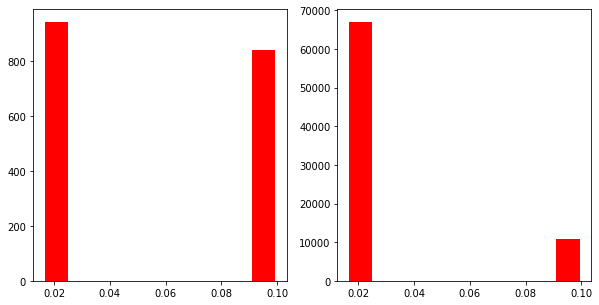

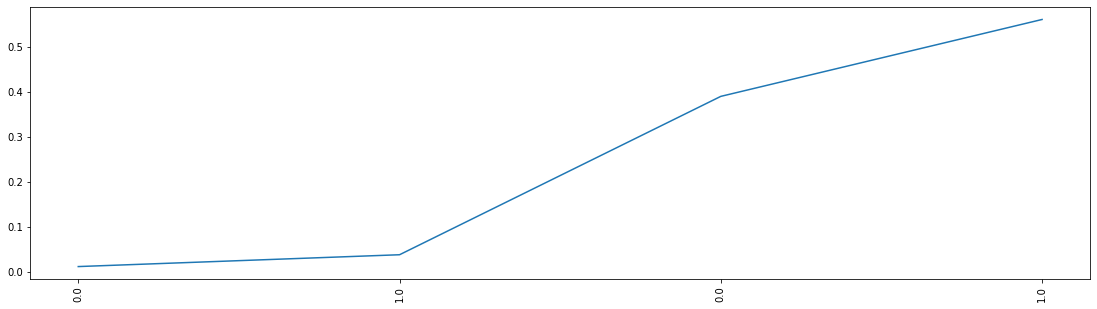

In [209]:
# train 201902-2019-05
#['Edad','Sexo','Recibe_sueldo_en_cuenta','Segmento_consumidor','Estado_civil','Principalidad']
# ['campains_202002-202005','Lectura_202002-202005','comunications_202002-202005']
# ['campains_202005-202008','Lectura_202005-202008','comunications_202005-202008']
features_customers = []
features_com_cam_train = ['Lectura_202002-202005','comunications_202002-202005']
features_com_cam_test =  ['Lectura_202005-202008','comunications_202005-202008']

features_train = features_customers + features_com_cam_train
features_test = features_customers + features_com_cam_test

X_train = data_A[features_train].astype(str) 
X_test = data_A[features_test].astype(str)

y_train = data_A['transactions_202002-202005']
y_test = data_A['transactions_202005-202008']

model = RandomForestClassifier()
encoder = OneHotEncoder()
encoder.fit(X_train.values)
 
model.fit(encoder.transform(X_train),y_train.values)

corte = 0.15
y_pred = (model.predict_proba(encoder.transform(X_test))[:,1] >corte)*1
y_pred_proba_1 = model.predict_proba(encoder.transform(X_test[y_test==1]))[:,1]
y_pred_proba_0 = model.predict_proba(encoder.transform(X_test[y_test==0]))[:,1]

precision = precision_score(y_test,y_pred)
print('precision in test:',precision)
print('*************************************************')
fig , ax = plt.subplots(ncols = 2, figsize =(10,5))
ax[0].hist(y_pred_proba_1,color='red')
ax[1].hist(y_pred_proba_0,color='red')
plt.show()
plt.figure(figsize=(19,5))
plt.plot(model.feature_importances_)
categorias = [el  for lista in encoder.categories_  for el in lista ]
plt.xticks( ticks=range(len(categorias)), labels=categorias ,rotation = 90)
plt.show()

In [210]:
corte = 0.06
y_pred = (model.predict_proba(encoder.transform(X_train))[:,1] >corte)*1


precision = precision_score(y_train,y_pred)
print('precision in test:',precision)
print('Mount 1 in prediction', sum(y_pred))
print('*************************************************')

precision in test: 0.09724593571375548
Mount 1 in prediction 13471
*************************************************


In [140]:
sum(data_A['Lectura_202005-202008'])

6474.0

In [98]:
sum(y_test)

2208.0

In [99]:
y_pred_proba_1

array([0.0125, 0.3   , 0.01  , ..., 0.    , 0.03  , 0.    ])

## Modelo B

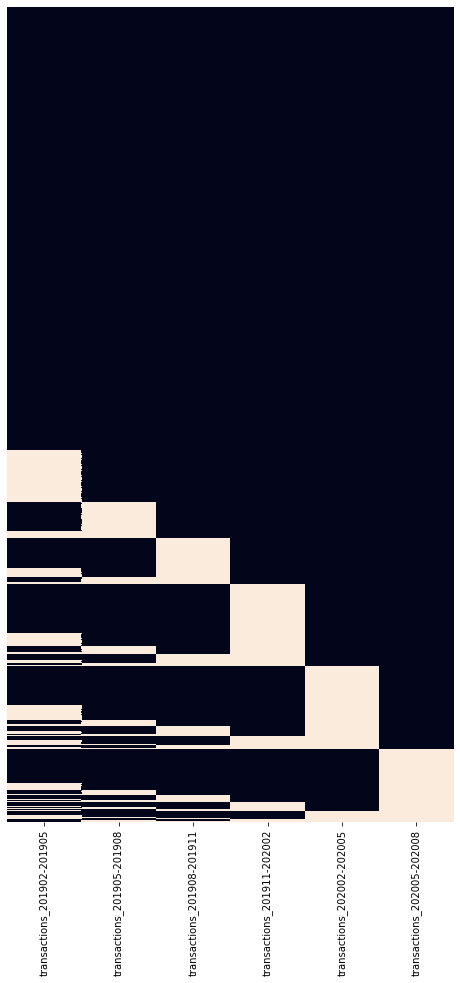

In [48]:
product = 'B-B'
data_B = get_data_model(product, transactions_train_df, comunications_train_df, campains_train_df, customers_df, dic_periods, plot = True)

In [65]:
list_transactions = [col for col in data_D.columns if 'transactions' in col]
hist_b = data_B[list_transactions]
send_b = hist_b.sum(axis=1) 
send_b.value_counts()

0.0    43258
1.0    22777
2.0     9303
3.0     3094
4.0      869
5.0      202
6.0       36
dtype: int64

precision in test: 0.14339622641509434
*************************************************


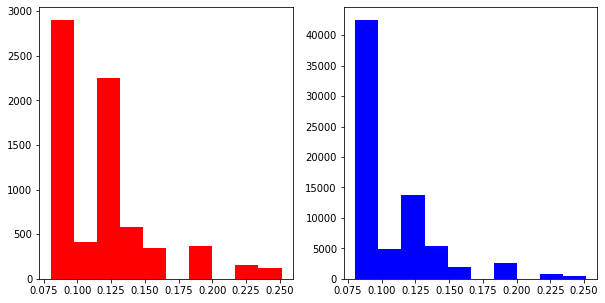

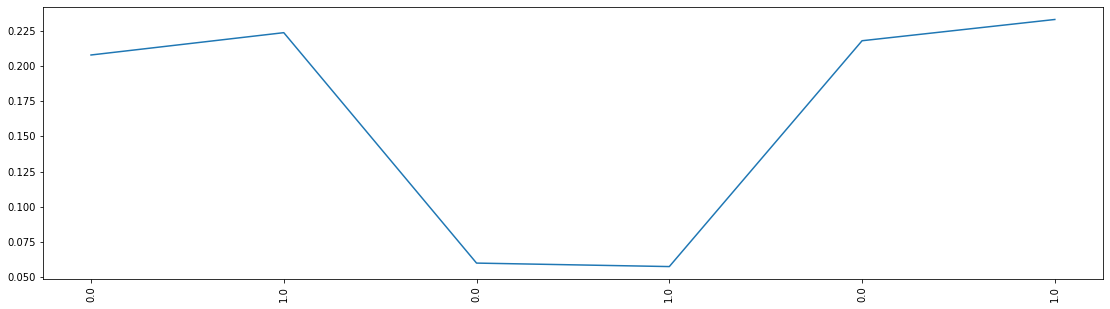

In [194]:
# train 201902-2019-05
#['Edad','Sexo','Recibe_sueldo_en_cuenta','Segmento_consumidor','Estado_civil','Principalidad']
# ['campains_202002-202005','Lectura_202002-202005','comunications_202002-202005']
# ['campains_202005-202008','Lectura_202005-202008','comunications_202005-202008']

# ['Edad','Sexo','Recibe_sueldo_en_cuenta','Segmento_consumidor','Estado_civil','Principalidad']  0.115
# ['Edad','Sexo','Recibe_sueldo_en_cuenta','Segmento_consumidor','Estado_civil'] 0.12
"""
features_customers = ['Ciudad']
features_com_cam_train = ['Lectura_202002-202005']
features_com_cam_test =  ['Lectura_202005-202008']   # 0.14 en test
"""
features_customers = []
features_com_cam_train = ['transactions_201908-201911','transactions_201911-202002','Lectura_202002-202005']
features_com_cam_test =  ['transactions_201911-202002','transactions_202002-202005','Lectura_202005-202008']


features_train = features_customers + features_com_cam_train
features_test = features_customers + features_com_cam_test

X_train = data_B[features_train].astype(str) 
X_test = data_B[features_test].astype(str)

y_train = data_B['transactions_202002-202005']
y_test = data_B['transactions_202005-202008']

model = RandomForestClassifier()
encoder = OneHotEncoder()
encoder.fit(X_train.values)
 
model.fit(encoder.transform(X_train),y_train.values)

corte = 0.15
y_pred = (model.predict_proba(encoder.transform(X_test))[:,1] >corte)*1
y_pred_proba_1 = model.predict_proba(encoder.transform(X_test[y_test==1]))[:,1]
y_pred_proba_0 = model.predict_proba(encoder.transform(X_test[y_test==0]))[:,1]

precision = precision_score(y_test,y_pred)
print('precision in test:',precision)
print('*************************************************')
fig , ax = plt.subplots(ncols = 2, figsize =(10,5))
ax[0].hist(y_pred_proba_1,color='red')
ax[1].hist(y_pred_proba_0,color='blue')
plt.show()
plt.figure(figsize=(19,5))
plt.plot(model.feature_importances_)
categorias = [el  for lista in encoder.categories_  for el in lista ]
plt.xticks( ticks=range(len(categorias)), labels=categorias ,rotation = 90)
plt.show()

In [198]:
corte = 0.22
y_pred = (model.predict_proba(encoder.transform(X_test))[:,1] >corte)*1


precision = precision_score(y_test,y_pred)
print('precision in test:',precision)
print('Mount 1 in prediction', sum(y_pred))
print('*************************************************')

precision in test: 0.17654557042702357
Mount 1 in prediction 1569
*************************************************


## Modelo C

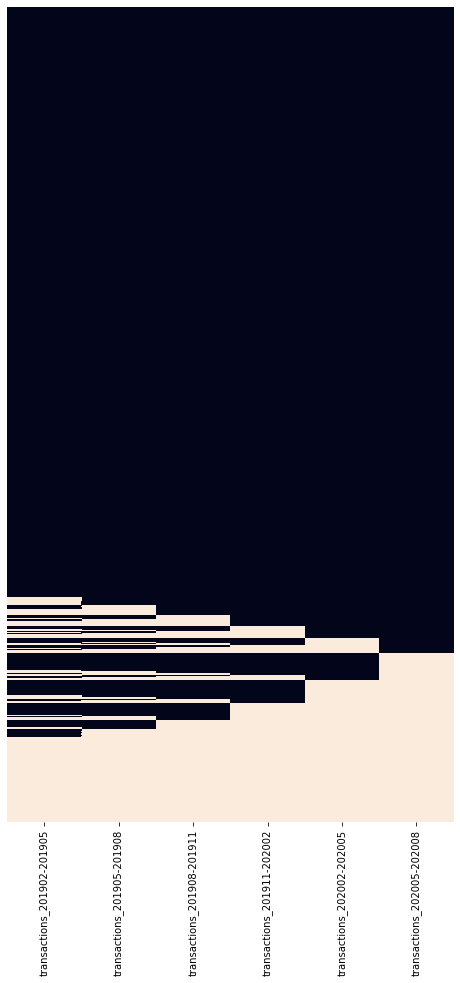

In [49]:
product = 'C-D'
data_C = get_data_model(product, transactions_train_df, comunications_train_df, campains_train_df, customers_df, dic_periods, plot = True)

In [66]:
list_transactions = [col for col in data_C.columns if 'transactions' in col]
hist_c = data_C[list_transactions]
send_c = hist_c.sum(axis=1) + 0.02
send_c.value_counts()

0.02    57550
6.02     8276
1.02     3790
2.02     3236
3.02     2649
5.02     2054
4.02     1984
dtype: int64

## Modelo D

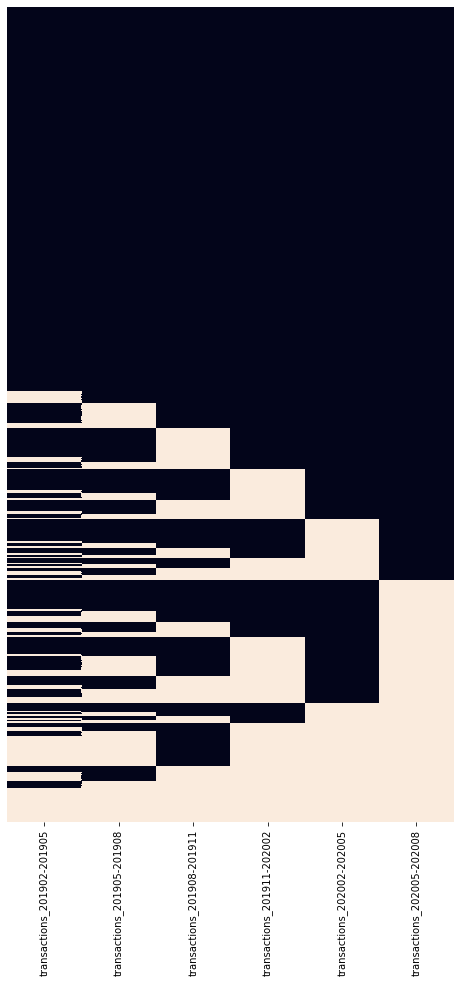

In [51]:
product = 'D-E'
data_D = get_data_model(product, transactions_train_df, comunications_train_df, campains_train_df, customers_df, dic_periods, plot = True)

In [67]:
list_transactions = [col for col in data_D.columns if 'transactions' in col]
hist_d = data_D[list_transactions]
send_d = hist_d.sum(axis=1)+ 0.01
send_d.value_counts()

0.01    37456
1.01    12905
2.01     8597
3.01     6929
5.01     5659
4.01     4715
6.01     3278
dtype: int64

## Modelo E

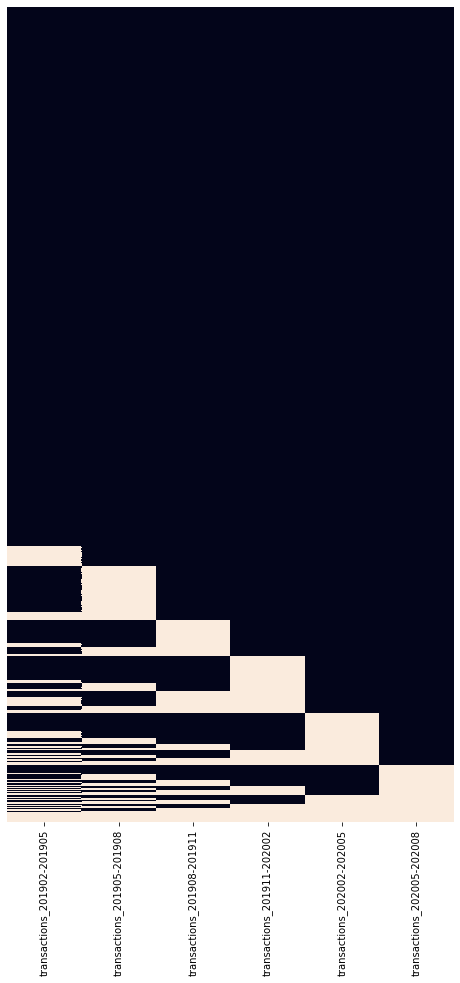

In [53]:
product = 'E-E'
data_E = get_data_model(product, transactions_train_df, comunications_train_df, campains_train_df, customers_df, dic_periods, plot = True)

In [68]:
list_transactions = [col for col in data_D.columns if 'transactions' in col]
hist_e = data_E[list_transactions]
send_e = hist_e.sum(axis=1)
send_e.value_counts()

0.0    52645
1.0    13534
2.0     6032
3.0     3606
4.0     1731
5.0     1056
6.0      935
dtype: int64

## working

In [39]:
customers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79539 entries, 0 to 79538
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               79539 non-null  int64  
 1   Edad                     79539 non-null  object 
 2   Sexo                     79539 non-null  int64  
 3   Renta                    79539 non-null  object 
 4   Recibe_sueldo_en_cuenta  79539 non-null  int64  
 5   Segmento_consumidor      79539 non-null  object 
 6   Meses_antiguedad         79539 non-null  object 
 7   Comuna                   79481 non-null  float64
 8   Ciudad                   79535 non-null  float64
 9   Estado_civil             79539 non-null  object 
 10  Principalidad            67378 non-null  object 
 11  Profesion                79118 non-null  object 
 12  id                       79539 non-null  int64  
dtypes: float64(2), int64(4), object(7)
memory usage: 7.9+ MB


In [40]:
customers_df.Comuna.unique()

array([3.310e+02, 3.700e+01, 1.900e+01, 9.100e+01, 7.100e+01, 3.400e+01,
       3.360e+02, 3.900e+01, 3.800e+01, 3.400e+02, 7.000e+01, 7.800e+01,
       3.320e+02, 9.200e+01, 7.200e+01, 9.900e+01, 7.000e+00, 3.220e+02,
       1.400e+02, 1.880e+02, 2.000e+00, 2.270e+02, 1.190e+02, 8.200e+01,
       9.400e+01, 9.300e+01, 2.480e+02, 1.890e+02, 1.050e+02, 3.430e+02,
       7.600e+01, 5.300e+01, 2.490e+02, 3.340e+02, 2.900e+02, 4.400e+01,
       1.590e+02, 1.900e+02, 2.430e+02, 8.500e+01, 1.110e+02, 6.000e+01,
       3.350e+02, 4.300e+01, 2.040e+02, 2.660e+02, 1.000e+02, 1.010e+02,
       1.990e+02, 2.610e+02, 2.080e+02, 3.300e+02, 1.500e+02, 3.370e+02,
       1.060e+02, 1.000e+00, 3.230e+02, 9.500e+01, 2.500e+01, 1.540e+02,
       8.300e+01, 3.280e+02, 3.600e+01, 3.260e+02, 1.040e+02, 2.100e+01,
       9.800e+01, 5.400e+01, 8.900e+01, 9.600e+01, 2.550e+02, 1.680e+02,
       8.100e+01, 2.410e+02, 3.440e+02, 3.270e+02, 1.000e+01, 3.330e+02,
       1.002e+03, 1.001e+03, 7.900e+01, 1.300e+01, 

In [41]:
customers_df.Ciudad.unique()

array([13.,  5.,  4.,  2.,  7.,  8.,  1.,  9.,  6., 10., 12., 14., 15.,
        3., 16., 11., nan])

In [42]:
campains_train_df['Duracion_Campaña'].value_counts()

1     474397
2      18916
7         10
12         2
11         2
9          1
Name: Duracion_Campaña, dtype: int64